# Unit test notebook for Fission Fragment 2

In [1]:
from cheftgp.eft import *
from cheftgp.gaussianprocess import *
from cheftgp.graphs import *
from cheftgp.scattering import *
from cheftgp.utils import *
from cheftgp.potentials import *
from scripts.generator_fns import *

import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.interpolate import interpn

%matplotlib inline

In [2]:
mpl.rc(
        "savefig",
        transparent=False,
        bbox="tight",
        pad_inches=0.05,
        dpi=300,
        format="png",
    )

In [3]:
import pandas as pd

lambdab_meff_data = [
["SMS" , "550MeV" , "N4LO+" , "ALL2DOBS" , 560 , 10 , 127 , 2 ,], 
["SMS" , "550MeV" , "N4LO" , "ALL2DOBS" , 450 , 10 , 110 , 3 ,], 
["SMS" , "550MeV" , "N3LO" , "ALL2DOBS" , 380 , 10 , 41 , 2 ,], 
["SMS" , "550MeV" , "N2LO" , "ALL2DOBS" , 370 , 20 , 38 , 2 ,], 
["SMS" , "500MeV" , "N4LO+" , "ALL2DOBS" , 570 , 10 , 138 , 3 ,], 
# ["SMS" , "500MeV" , "N4LO" , , , , ,], 
# ["SMS" , "500MeV" , "N3LO" , , , , ,], 
# ["SMS" , "500MeV" , "N2LO" , , , , ,], 
["SMS" , "450MeV" , "N4LO+" , "ALL2DOBS" , 580 , 10 , 154 , 3 ,], 
["SMS" , "450MeV" , "N4LO" , "ALL2DOBS" , 570 , 20 , 130 , 3 ,], 
["SMS" , "450MeV" , "N3LO" , "ALL2DOBS" , 460 , 20 , 95 , 4 ,], 
["SMS" , "450MeV" , "N2LO" , "ALL2DOBS" , 510 , 30 , 32 , 2 ,], 
["SMS" , "400MeV" , "N4LO+" , "ALL2DOBS" , 610 , 10 , 163 , 3 ,], 
["SMS" , "400MeV" , "N4LO" , "ALL2DOBS" , 540 , 20 , 123 , 4 ,], 
["SMS" , "400MeV" , "N3LO" , "ALL2DOBS" , 400 , 10 , 104 , 4 ,], 
["SMS" , "400MeV" , "N2LO" , "ALL2DOBS" , 630 , 30 , 35 , 3 ,], 
["SCS" , "0.8fm" , "N4LO" , "ALL2DOBS" , 590 , 20 , 105 , 3 ,], 
["SCS" , "0.8fm" , "N3LO" , "ALL2DOBS" , 440 , 10 , 48 , 2 ,], 
["SCS" , "0.8fm" , "N2LO" , "ALL2DOBS" , 400 , 20 , 36 , 2 ,], 
["SCS" , "0.9fm" , "N4LO" , "ALL2DOBS" , 720 , 20 , 120. , 3 ,], 
["SCS" , "0.9fm" , "N3LO" , "ALL2DOBS" , 610 , 20 , 69 , 3 ,], 
["SCS" , "0.9fm" , "N2LO" , "ALL2DOBS" , 490 , 30 , 40 , 3 ,], 
["SCS" , "1.0fm" , "N4LO" , "ALL2DOBS" , 680 , 20 , 122 , 3 ,], 
["SCS" , "1.0fm" , "N3LO" , "ALL2DOBS" , 520 , 20 , 80 , 3 ,], 
["SCS" , "1.0fm" , "N2LO" , "ALL2DOBS" , 640 , 40 , 47 , 3 ,], 
["SCS" , "1.1fm" , "N4LO" , "ALL2DOBS" , 620 , 20 , 117 , 3 ,], 
["SCS" , "1.1fm" , "N3LO" , "ALL2DOBS" , 460 , 10 , 81 , 3 ,], 
["SCS" , "1.1fm" , "N2LO" , "ALL2DOBS" , 790 , 50 , 53 , 3 ,], 
["SCS" , "1.2fm" , "N4LO" , "ALL2DOBS" , 570 , 20 , 112 , 3 ,], 
["SCS" , "1.2fm" , "N3LO" , "ALL2DOBS" , 400 , 10 , 75 , 3 ,], 
["SCS" , "1.2fm" , "N2LO" , "ALL2DOBS" , 850 , 50 , 54 , 3 ,], 
["EMN" , "550MeV" , "N4LO" , "ALL2DOBS" , 530 , 20 , 75 , 2 ,], 
["EMN" , "550MeV" , "N3LO" , "ALL2DOBS" , 380 , 10 , 41 , 2 ,], 
["EMN" , "550MeV" , "N2LO" , "ALL2DOBS" , 420 , 20 , 5 , 1 ,], 
["EMN" , "500MeV" , "N4LO" , "ALL2DOBS" , 510 , 10 , 63 , 2 ,], 
# ["EMN" , "500MeV" , "N3LO" , , , , ,], 
# ["EMN" , "500MeV" , "N2LO" , , , , ,], 
["EMN" , "450MeV" , "N4LO" , "ALL2DOBS" , 480 , 10 , 62 , 2 ,], 
["EMN" , "450MeV" , "N3LO" , "ALL2DOBS" , 400 , 10 , 36 , 2 ,], 
["EMN" , "450MeV" , "N2LO" , "ALL2DOBS" , 410 , 20 , 15 , 2 ,], 
["GT+" , "0.9fm" , "N2LO" , "ALL2DOBS" , 560 , 30 , 21 , 2 ,], 
["GT+" , "1.0fm" , "N2LO" , "ALL2DOBS" , 720 , 40 , 22 , 1 ,], 
["GT+" , "1.1fm" , "N2LO" , "ALL2DOBS" , 890 , 50 , 24 , 2 ,], 
["GT+" , "1.2fm" , "N2LO" , "ALL2DOBS" , 1010 , 60 , 24 , 1 ,], 
# ["Norfolk" , "(0.8,0.6)fm" , "N2LO" , , , , ,], 
# ["Norfolk" , "(1.0,0.7)fm" , "N2LO" , , , , ,], 
# ["Norfolk" , "(1.2,0.8)fm" , "N2LO" , , , , ,], 
# ["GO" , "500MeV" , "N2LO" , , , , ,], 
# ["GO" , "450MeV" , "N2LO" , , , , ,], 
    
["SMS" , "550MeV" , "N4LO+" , "SGT" , 900 , 100 , 320 , 50 ,], 
["SMS" , "550MeV" , "N4LO" , "SGT" , 700 , 100 , 340 , 80 ,], 
["SMS" , "550MeV" , "N3LO" , "SGT" , 700 , 100 , 300 , 100 ,], 
# ["SMS" , "550MeV" , "N2LO" , "SGT" ,  ,  ,  ,  ,], 
["SMS" , "500MeV" , "N4LO+" , "SGT" , 1100 , 100 , 370 , 60 ,], 
["SMS" , "500MeV" , "N4LO" , "SGT" , 1000 , 200 , 390 , 90 ,], 
["SMS" , "500MeV" , "N3LO" , "SGT" , 1100 , 300 , 400 , 200 ,], 
# ["SMS" , "500MeV" , "N2LO" , , , , ,], 
["SMS" , "450MeV" , "N4LO+" , "SGT" , 1100 , 200 , 440 , 70 ,], 
["SMS" , "450MeV" , "N4LO" , "SGT" , 1000 , 200 , 460 , 90 ,], 
["SMS" , "450MeV" , "N3LO" , "SGT" , 900 , 200 , 480 , 90 ,], 
# ["SMS" , "450MeV" , "N2LO" , "SGT" ,  ,  ,  ,  ,], 
["SMS" , "400MeV" , "N4LO+" , "SGT" , 1000 , 200 , 430 , 60 ,], 
["SMS" , "400MeV" , "N4LO" , "SGT" , 800 , 200 , 400 , 70 ,], 
["SMS" , "400MeV" , "N3LO" , "SGT" , 700 , 100 , 400 , 90 ,], 
# ["SMS" , "400MeV" , "N2LO" , "SGT" ,  ,  ,  ,  ,], 
["SCS" , "0.8fm" , "N4LO" , "SGT" , 700 , 100 , 250 , 60 ,], 
["SCS" , "0.8fm" , "N3LO" , "SGT" , 700 , 200 , 200 , 100 ,], 
["SCS" , "0.8fm" , "N2LO" , "SGT" , 1100 , 500 , 400 , 100 ,], 
["SCS" , "0.9fm" , "N4LO" , "SGT" , 900 , 100 , 300 , 60 ,], 
["SCS" , "0.9fm" , "N3LO" , "SGT" , 900 , 200 , 350 , 90 ,], 
["SCS" , "0.9fm" , "N2LO" , "SGT" , 1400 , 500 , 500 , 100 ,], 
["SCS" , "1.0fm" , "N4LO" , "SGT" , 700 , 100 , 290 , 80 ,], 
["SCS" , "1.0fm" , "N3LO" , "SGT" , 700 , 100 , 300 , 100 ,], 
["SCS" , "1.0fm" , "N2LO" , "SGT" , 1600 , 500 , 500 , 100 ,], 
["SCS" , "1.1fm" , "N4LO" , "SGT" , 600 , 100 , 240 , 60 ,], 
["SCS" , "1.1fm" , "N3LO" , "SGT" , 600 , 100 , 300 , 100 ,], 
["SCS" , "1.1fm" , "N2LO" , "SGT" , 1700 , 400 , 500 , 100 ,], 
["SCS" , "1.2fm" , "N4LO" , "SGT" , 570 , 90 , 200 , 40 ,], 
["SCS" , "1.2fm" , "N3LO" , "SGT" , 500 , 80 , 210 , 90 ,], 
["SCS" , "1.2fm" , "N2LO" , "SGT" , 1900 , 400 , 500 , 100 ,], 
["EMN" , "550MeV" , "N4LO" , "SGT" , 1000 , 200 , 160 , 40 ,], 
["EMN" , "550MeV" , "N3LO" , "SGT" , 800 , 200 , 130 , 50 ,], 
["EMN" , "550MeV" , "N2LO" , "SGT" , 900 , 400 , 150 , 90 ,], 
["EMN" , "500MeV" , "N4LO" , "SGT" , 1300 , 300 , 210 , 50 ,], 
["EMN" , "500MeV" , "N3LO" , "SGT" , 800 , 200 , 120 , 40 ,], 
["EMN" , "500MeV" , "N2LO" , "SGT" , 800 , 300 , 140 , 70 ,], 
["EMN" , "450MeV" , "N4LO" , "SGT" , 900 , 200 , 150 , 30 ,], 
["EMN" , "450MeV" , "N3LO" , "SGT" , 700 , 200 , 120 , 30 ,], 
["EMN" , "450MeV" , "N2LO" , "SGT" , 700 , 300 , 140 , 70 ,], 
["GT+" , "0.9fm" , "N2LO" , "SGT" , 1500 , 500 , 400 , 100 ,], 
["GT+" , "1.0fm" , "N2LO" , "SGT" , 1700 , 500 , 400 , 100 ,], 
["GT+" , "1.1fm" , "N2LO" , "SGT" , 1800, 400 , 400, 100 ,], 
["GT+" , "1.2fm" , "N2LO" , "SGT" , 1900, 500 , 400 , 100 ,], 
# ["Norfolk" , "(0.8,0.6)fm" , "N2LO" , , , , ,], 
# ["Norfolk" , "(1.0,0.7)fm" , "N2LO" , , , , ,], 
# ["Norfolk" , "(1.2,0.8)fm" , "N2LO" , , , , ,], 
# ["GO" , "500MeV" , "N2LO" , , , , ,], 
# ["GO" , "450MeV" , "N2LO" , , , , ,], 
]

lambda_meff_df = pd.DataFrame(lambdab_meff_data, 
        columns = ["Potential", "Cutoff", "Max. order", "Observable(s)", 
                   "Lambdab_mean", "Lambdab_stddev", "meff_mean", "meff_stddev"])

lambda_meff_df

,Potential,Cutoff,Max. order,Observable(s),Lambdab_mean,Lambdab_stddev,meff_mean,meff_stddev
0,SMS,550MeV,N4LO+,ALL2DOBS,560,10,127.0,2
1,SMS,550MeV,N4LO,ALL2DOBS,450,10,110.0,3
2,SMS,550MeV,N3LO,ALL2DOBS,380,10,41.0,2
3,SMS,550MeV,N2LO,ALL2DOBS,370,20,38.0,2
4,SMS,500MeV,N4LO+,ALL2DOBS,570,10,138.0,3
...,...,...,...,...,...,...,...,...
74,EMN,450MeV,N2LO,SGT,700,300,140.0,70
75,GT+,0.9fm,N2LO,SGT,1500,500,400.0,100
76,GT+,1.0fm,N2LO,SGT,1700,500,400.0,100
77,GT+,1.1fm,N2LO,SGT,1800,400,400.0,100


In [4]:
potential_color_dict = {"SMS" : "dodgerblue", "SCS" : "deeppink", 
                       "GT+" : "darkorange", "EMN" : "forestgreen"}
order_marker_dict = {"N4LO+" : "d", "N4LO" : "s", "N3LO" : "^", "N2LO" : "o"}
order_name_order_label_dict = {"N4LO+" : "N$^{4}$LO+", "N4LO" : "N$^{4}$LO", 
                        "N3LO" : "N$^{3}$LO", "N2LO" : "N$^{2}$LO"}
order_name_coeff_name_dict = {"N4LO+" : "c6", "N4LO" : "c5", "N3LO" : "c4", "N2LO" : "c3"}
order_name_coeff_label_dict = {"N4LO+" : "$c_{6}$", "N4LO" : "$c_{5}$", 
                               "N3LO" : "$c_{4}$", "N2LO" : "$c_{3}$"}

In [5]:
def Lambdab_meff_linear(x, a, b):
    return a * x + b

In [6]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


EMN (N2LO): Lambda_b = (-1.0 +/- inf) m_eff + (425 +/- inf) MeV
EMN (N3LO): Lambda_b = (-4.0 +/- inf) m_eff + (544 +/- inf) MeV
EMN (N4LO): Lambda_b = (2.9 +/- 1.9) m_eff + (311 +/- 126) MeV
GT+ (N2LO): Lambda_b = (126.7 +/- 24.0) m_eff + (-2087 +/- 548) MeV
SCS (N2LO): Lambda_b = (24.1 +/- 1.2) m_eff + (-476 +/-  56) MeV
SCS (N3LO): Lambda_b = (0.7 +/- 3.5) m_eff + (436 +/- 249) MeV
SCS (N4LO): Lambda_b = (7.2 +/- 3.2) m_eff + (-199 +/- 374) MeV
SMS (N2LO): Lambda_b = (-23.3 +/- 36.6) m_eff + (1320 +/- 1283) MeV
SMS (N3LO): Lambda_b = (0.7 +/- 1.0) m_eff + (355 +/-  83) MeV
SMS (N4LO): Lambda_b = (6.1 +/- 0.7) m_eff + (-220 +/-  82) MeV
SMS (N4LO+): Lambda_b = (1.2 +/- 0.3) m_eff + (398 +/-  51) MeV


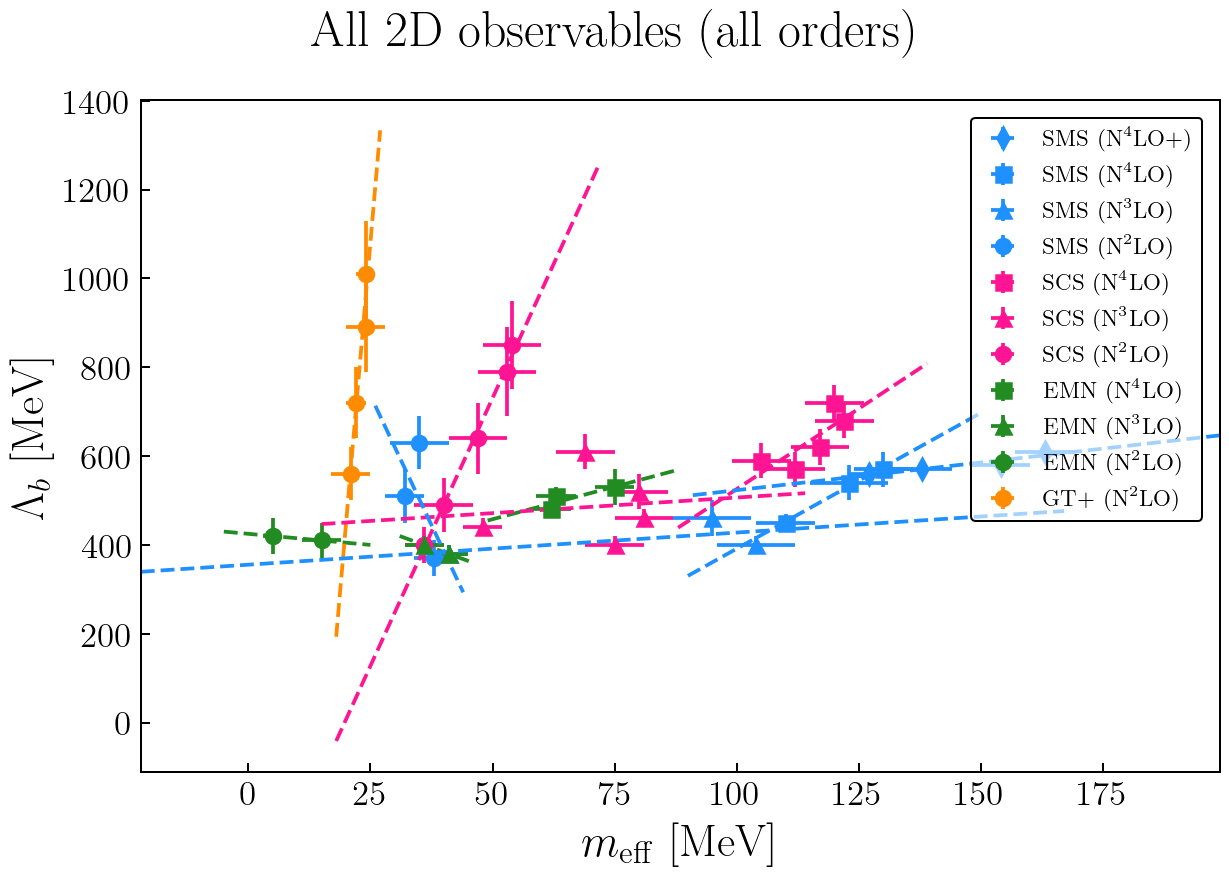

In [7]:
fig_fit_all2dobs_allo, ax_fit_all2dobs_allo = plt.subplots(figsize=(7,5))

# for index, row in lambda_meff_df.iterrows():
#     # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
#     ax_fit_all2dobs_allo.errorbar(row["meff_mean"], row["Lambdab_mean"], 
#                     xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
#                     color = potential_color_dict[row["Potential"]], 
#                     label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
#                     fmt = order_marker_dict[row["Max. order"]])
    
for index, row in lambda_meff_df[lambda_meff_df["Observable(s)"] == "ALL2DOBS"].iterrows():
    # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
    ax_fit_all2dobs_allo.errorbar(row["meff_mean"], row["Lambdab_mean"], 
                    xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
                    color = potential_color_dict[row["Potential"]], 
                    label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
                    fmt = order_marker_dict[row["Max. order"]])

pot_order_combo = lambda_meff_df[lambda_meff_df["Observable(s)"] == "ALL2DOBS"].groupby(['Potential', 'Max. order'])

for (pot, order), row in pot_order_combo:
#     print(pot)
#     print(order)
#     print(row)
    # fits the points to a line
    popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
                        row["meff_mean"], row["Lambdab_mean"])
    # plots the line of best fit
    ax_fit_all2dobs_allo.plot(
        np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
                    2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
                    100), 
                Lambdab_meff_linear(
                    np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
                                2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
                                100), 
                    popt[0], popt[1]), 
                color = potential_color_dict[pot], 
               linestyle = "--", 
#                label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$"
               )
    # prints the best fit values
    print(pot + " (" + order + f"): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
         f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

fig_fit_all2dobs_allo.suptitle("All 2D observables (all orders)", fontsize = 20)
ax_fit_all2dobs_allo.set_xlabel("$m_{\mathrm{eff}}$ [MeV]", fontsize = 18)
ax_fit_all2dobs_allo.set_ylabel(r"$\Lambda_{b}$ [MeV]", fontsize = 18)
# ax_fit.legend(fontsize = 10, 
#               loc = 'upper right', 
#               ncols = 2)
ax_fit_all2dobs_allo.legend(
            fontsize = 10,
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          handletextpad=0.02,
          borderpad=0.2)

legend_without_duplicate_labels(ax_fit_all2dobs_allo)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig_fit_all2dobs_allo.tight_layout()
plt.show()
fig_fit_all2dobs_allo.savefig('figures2/' + 'Lambdab_vs_meff_all2dobs_allo')

In [8]:
# fig_fit_sgt_allo, ax_fit_sgt_allo = plt.subplots(figsize=(7,5))

# # for index, row in lambda_meff_df.iterrows():
# #     # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
# #     ax_fit_all2dobs_allo.errorbar(row["meff_mean"], row["Lambdab_mean"], 
# #                     xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
# #                     color = potential_color_dict[row["Potential"]], 
# #                     label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
# #                     fmt = order_marker_dict[row["Max. order"]])
    
# for index, row in lambda_meff_df[lambda_meff_df["Observable(s)"] == "ALL2DOBS"].iterrows():
#     # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
#     ax_fit_all2dobs_allo.errorbar(row["meff_mean"], row["Lambdab_mean"], 
#                     xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
#                     color = potential_color_dict[row["Potential"]], 
#                     label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
#                     fmt = order_marker_dict[row["Max. order"]])

# pot_order_combo = lambda_meff_df[lambda_meff_df["Observable(s)"] == "ALL2DOBS"].groupby(['Potential', 'Max. order'])

# for (pot, order), row in pot_order_combo:
# #     print(pot)
# #     print(order)
# #     print(row)
#     # fits the points to a line
#     popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
#                         row["meff_mean"], row["Lambdab_mean"])
#     # plots the line of best fit
#     ax_fit_all2dobs_allo.plot(
#         np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
#                     2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
#                     100), 
#                 Lambdab_meff_linear(
#                     np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
#                                 2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
#                                 100), 
#                     popt[0], popt[1]), 
#                 color = potential_color_dict[pot], 
#                linestyle = "--", 
# #                label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$"
#                )
#     # prints the best fit values
#     print(pot + " (" + order + f"): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
#          f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# fig_fit_all2dobs_allo.suptitle("All 2D observables (all orders)", fontsize = 20)
# ax_fit_all2dobs_allo.set_xlabel("$m_{\mathrm{eff}}$ [MeV]", fontsize = 18)
# ax_fit_all2dobs_allo.set_ylabel(r"$\Lambda_{b}$ [MeV]", fontsize = 18)
# # ax_fit.legend(fontsize = 10, 
# #               loc = 'upper right', 
# #               ncols = 2)
# ax_fit_all2dobs_allo.legend(
#             fontsize = 10,
#           loc='center left',
#           bbox_to_anchor=(1, 0.5),
#           handletextpad=0.02,
#           borderpad=0.2)

# legend_without_duplicate_labels(ax_fit_all2dobs_allo)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# fig_fit_all2dobs_allo.tight_layout()
# plt.show()
# fig_fit_all2dobs_allo.savefig('figures2/' + 'Lambdab_vs_meff_sgt_allo')

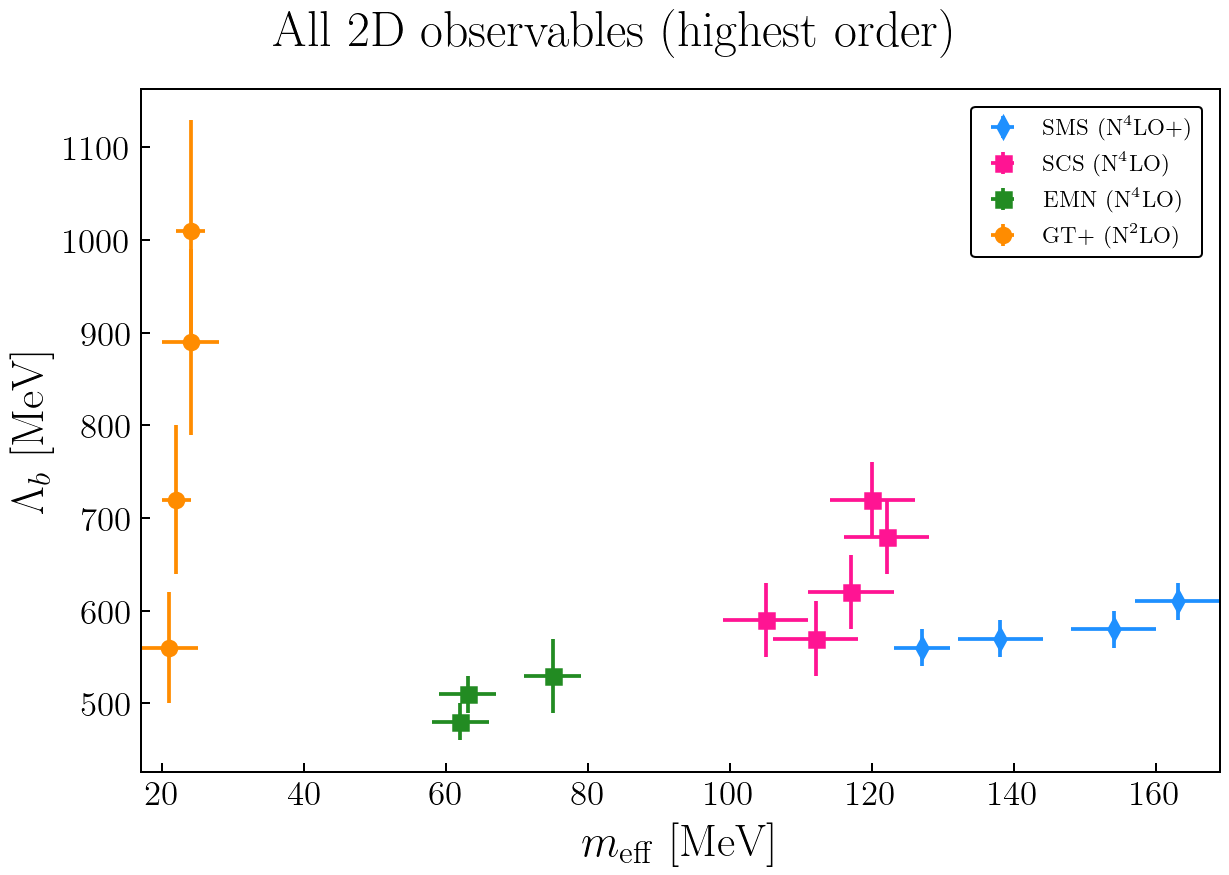

In [9]:
fig_fit_all2dobs_ho, ax_fit_all2dobs_ho = plt.subplots(figsize=(7,5))

# for index, row in lambda_meff_df.iterrows():
#     # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
#     ax_fit_all2dobs_ho.errorbar(row["meff_mean"], row["Lambdab_mean"], 
#                     xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
#                     color = potential_color_dict[row["Potential"]], 
#                     label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
#                     fmt = order_marker_dict[row["Max. order"]])

pot_cutoff_combo = lambda_meff_df[lambda_meff_df["Observable(s)"] == "ALL2DOBS"].groupby(['Potential', 'Cutoff']).head(1)
# pot_cutoff_combo
for index, row in pot_cutoff_combo.iterrows():
#     print(pot)
#     print(order)
#     print(row)
    # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
    ax_fit_all2dobs_ho.errorbar(row["meff_mean"], row["Lambdab_mean"], 
                    xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
                    color = potential_color_dict[row["Potential"]], 
                    label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
                    fmt = order_marker_dict[row["Max. order"]])
#     # fits the points to a line
#     popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
#                         row["meff_mean"], row["Lambdab_mean"])
#     # plots the line of best fit
#     ax_fit_all2dobs_ho.plot(
#         np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
#                     2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
#                     100), 
#                 Lambdab_meff_linear(
#                     np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
#                                 2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
#                                 100), 
#                     popt[0], popt[1]), 
#                 color = potential_color_dict[pot], 
#                 linestyle = "--", 
# #                label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$"
#                )
#     # prints the best fit values
#     print(pot + " (" + row["Max. order"] + f"): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
#          f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

fig_fit_all2dobs_ho.suptitle("All 2D observables (highest order)", fontsize = 20)
ax_fit_all2dobs_ho.set_xlabel("$m_{\mathrm{eff}}$ [MeV]", fontsize = 18)
ax_fit_all2dobs_ho.set_ylabel(r"$\Lambda_{b}$ [MeV]", fontsize = 18)
# ax_fit.legend(fontsize = 10, 
#               loc = 'upper right', 
#               ncols = 2)
ax_fit_all2dobs_ho.legend(
            fontsize = 10,
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          handletextpad=0.02,
          borderpad=0.2)

legend_without_duplicate_labels(ax_fit_all2dobs_ho)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig_fit_all2dobs_ho.tight_layout()
plt.show()
fig_fit_all2dobs_ho.savefig('figures2/' + 'Lambdab_vs_meff_all2dobs_ho')

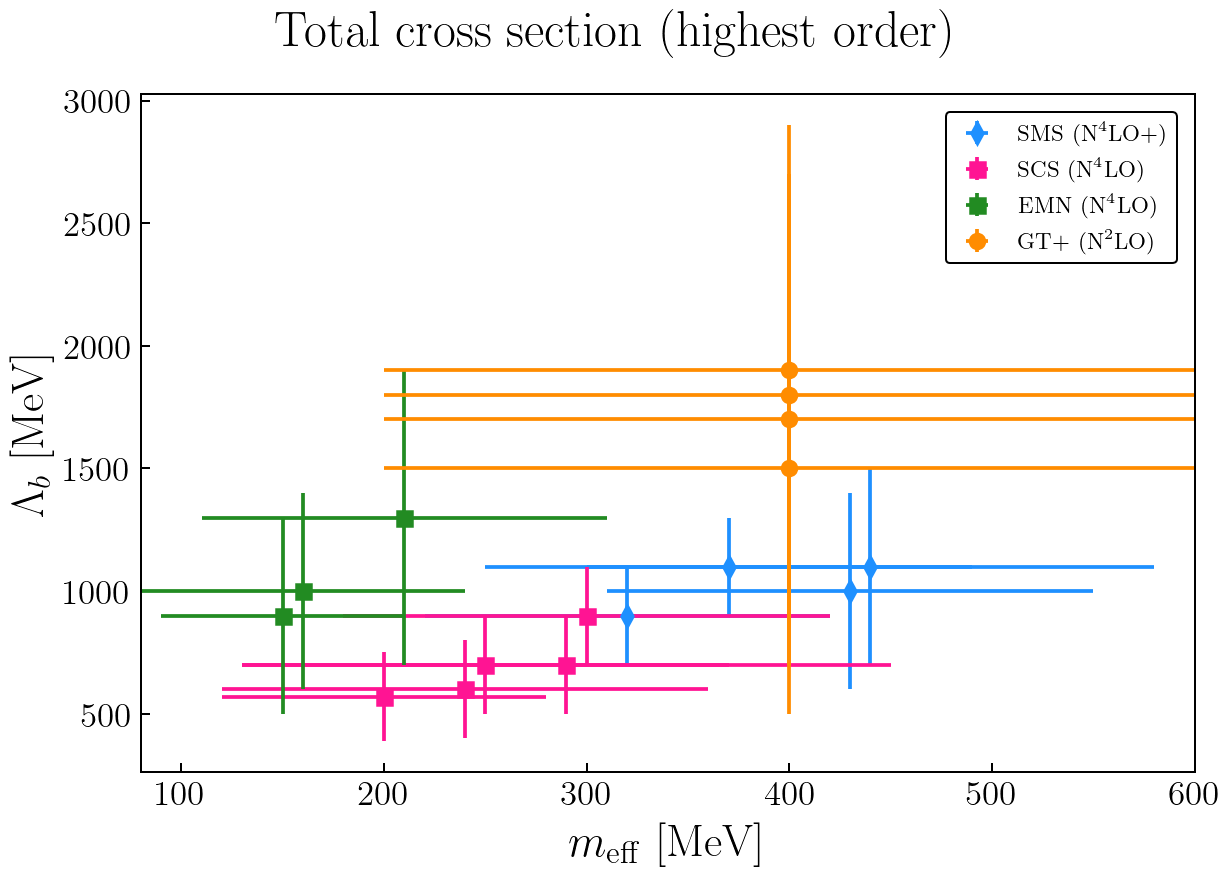

In [10]:
fig_fit_sgt_ho, ax_fit_sgt_ho = plt.subplots(figsize=(7,5))

# for index, row in lambda_meff_df.iterrows():
#     # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
#     ax_fit_all2dobs_ho.errorbar(row["meff_mean"], row["Lambdab_mean"], 
#                     xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
#                     color = potential_color_dict[row["Potential"]], 
#                     label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
#                     fmt = order_marker_dict[row["Max. order"]])

pot_cutoff_combo = lambda_meff_df[lambda_meff_df["Observable(s)"] == "SGT"].groupby(['Potential', 'Cutoff']).head(1)
# pot_cutoff_combo
for index, row in pot_cutoff_combo.iterrows():
#     print(pot)
#     print(order)
#     print(row)
    # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
    ax_fit_sgt_ho.errorbar(row["meff_mean"], row["Lambdab_mean"], 
                    xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
                    color = potential_color_dict[row["Potential"]], 
                    label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
                    fmt = order_marker_dict[row["Max. order"]])
#     # fits the points to a line
#     popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
#                         row["meff_mean"], row["Lambdab_mean"])
#     # plots the line of best fit
#     ax_fit_all2dobs_ho.plot(
#         np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
#                     2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
#                     100), 
#                 Lambdab_meff_linear(
#                     np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
#                                 2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
#                                 100), 
#                     popt[0], popt[1]), 
#                 color = potential_color_dict[pot], 
#                 linestyle = "--", 
# #                label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$"
#                )
#     # prints the best fit values
#     print(pot + " (" + row["Max. order"] + f"): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
#          f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

fig_fit_sgt_ho.suptitle("Total cross section (highest order)", fontsize = 20)
ax_fit_sgt_ho.set_xlabel("$m_{\mathrm{eff}}$ [MeV]", fontsize = 18)
ax_fit_sgt_ho.set_ylabel(r"$\Lambda_{b}$ [MeV]", fontsize = 18)
# ax_fit.legend(fontsize = 10, 
#               loc = 'upper right', 
#               ncols = 2)
ax_fit_sgt_ho.legend(
            fontsize = 10,
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          handletextpad=0.02,
          borderpad=0.2)

legend_without_duplicate_labels(ax_fit_sgt_ho)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig_fit_sgt_ho.tight_layout()
plt.show()
fig_fit_sgt_ho.savefig('figures2/' + 'Lambdab_vs_meff_sgt_ho')

| Potential | Cutoff | Max. order (Max. coefficient) | $\Lambda_{b}$ (MeV) | $m_{\mathrm{eff}}$ (MeV) |
|:---:|:---:|:---:|:---|:---|
| SMS | 550 MeV | N$^{4}$LO+ ($c_{6}$) | $560 \pm 10$ | $127 \pm 2$ |
| SMS | 550 MeV | N$^{4}$LO ($c_{5}$) | $450 \pm 10$ | $110 \pm 3$ |
| SMS | 550 MeV | N$^{3}$LO ($c_{4}$) | $380 \pm 10$ | $41 \pm 2$ |
| SMS | 550 MeV | N$^{2}$LO ($c_{3}$) | $370 \pm 20$ | $38 \pm 2$ |
| SMS | 500 MeV | N$^{4}$LO+ ($c_{6}$) | $570 \pm 10$ | $138 \pm 3$ |
| SMS | 500 MeV | N$^{4}$LO ($c_{5}$) | $\pm$ | $\pm$ |
| SMS | 500 MeV | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SMS | 500 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| SMS | 450 MeV | N$^{4}$LO+ ($c_{6}$) | $580 \pm 10$ | $154 \pm 3$ |
| SMS | 450 MeV | N$^{4}$LO ($c_{5}$) | $570 \pm 20$ | $130 \pm 3$ |
| SMS | 450 MeV | N$^{3}$LO ($c_{4}$) | $460 \pm 20$ | $95 \pm 4$ |
| SMS | 450 MeV | N$^{2}$LO ($c_{3}$) | $510 \pm 30$ | $32 \pm 2$ |
| SMS | 400 MeV | N$^{4}$LO+ ($c_{6}$) | $610 \pm 10$ | $163 \pm 3$ |
| SMS | 400 MeV | N$^{4}$LO ($c_{5}$) | $540 \pm 20$ | $123 \pm 4$ |
| SMS | 400 MeV | N$^{3}$LO ($c_{4}$) | $400 \pm 10$ | $104 \pm 4$ |
| SMS | 400 MeV | N$^{2}$LO ($c_{3}$) | $630 \pm 30$ | $35 \pm 3$ |
| SCS | 0.8 fm | N$^{4}$LO ($c_{5}$) | $590 \pm 20$ | $105 \pm 3$ |
| SCS | 0.8 fm | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SCS | 0.8 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| SCS | 0.9 fm | N$^{4}$LO ($c_{5}$) | $720 \pm 20$ | $120. \pm 3$ |
| SCS | 0.9 fm | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SCS | 0.9 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| SCS | 1.0 fm | N$^{4}$LO ($c_{5}$) | $680 \pm 20$ | $122 \pm 3$ |
| SCS | 1.0 fm | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SCS | 1.0 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| SCS | 1.1 fm | N$^{4}$LO ($c_{5}$) | $620 \pm 20$ | $117 \pm 3$ |
| SCS | 1.1 fm | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SCS | 1.1 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| SCS | 1.2 fm | N$^{4}$LO ($c_{5}$) | $570 \pm 20$ | $111 \pm 3$ |
| SCS | 1.2 fm | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| SCS | 1.2 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 550 MeV | N$^{4}$LO ($c_{5}$) | $530 \pm 20$ | $75 \pm 2$ |
| EMN (Idaho) | 550 MeV | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 550 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 500 MeV | N$^{4}$LO ($c_{5}$) | $510 \pm 10$ | $63 \pm 2$ |
| EMN (Idaho) | 500 MeV | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 500 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 450 MeV | N$^{4}$LO ($c_{5}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 450 MeV | N$^{3}$LO ($c_{4}$) | $\pm$ | $\pm$ |
| EMN (Idaho) | 450 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| GT+ | 0.9 fm | N$^{2}$LO ($c_{3}$) | $560 \pm 30$ | $21 \pm 2$ |
| GT+ | 1.0 fm | N$^{2}$LO ($c_{3}$) | $720 \pm 40$ | $22 \pm 1$ |
| GT+ | 1.1 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| GT+ | 1.2 fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| Norfolk | (0.8, 0.6) fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| Norfolk | (1.0, 0.7) fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| Norfolk | (1.2, 0.8) fm | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| GO | 500 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |
| GO | 450 MeV | N$^{2}$LO ($c_{3}$) | $\pm$ | $\pm$ |

In [11]:
# from sklearn.linear_model import LinearRegression

# # means and standard deviations for SMS to N4LO+
# Lambdab_sms_n4lop_pts = np.array([560, 570, 580, 610])
# Lambdab_sms_n4lop_stddev = np.array([10, 10, 10, 10])
# meff_sms_n4lop_pts = np.array([127, 138, 154, 163])
# meff_sms_n4lop_stddev = np.array([2, 3, 3, 3])

# # means and standard deviations for SMS to N4LO
# Lambdab_sms_n4lo_pts = np.array([450, 570, 540, ])
# Lambdab_sms_n4lo_stddev = np.array([10, 20, 20, ])
# meff_sms_n4lo_pts = np.array([110, 130, 123, ])
# meff_sms_n4lo_stddev = np.array([3, 3, 4, ])

# # means and standard deviations for SMS to N3LO
# Lambdab_sms_n3lo_pts = np.array([380, 460, 400, ])
# Lambdab_sms_n3lo_stddev = np.array([10, 20, 10, ])
# meff_sms_n3lo_pts = np.array([41, 95, 104, ])
# meff_sms_n3lo_stddev = np.array([2, 4, 4, ])

# # means and standard deviations for SMS to N2LO
# Lambdab_sms_n2lo_pts = np.array([370, 510, 630, ])
# Lambdab_sms_n2lo_stddev = np.array([20, 30, 30, ])
# meff_sms_n2lo_pts = np.array([38, 32, 35, ])
# meff_sms_n2lo_stddev = np.array([2, 2, 3, ])

# # means and standard deviations for SCS to N4LO
# Lambdab_scs_n4lo_pts = np.array([590, 720, 680, 620, 570])
# Lambdab_scs_n4lo_stddev = np.array([20, 20, 20, 20, 20])
# meff_scs_n4lo_pts = np.array([105, 120, 122, 117, 111])
# meff_scs_n4lo_stddev = np.array([3, 3, 3, 3, 3])

# # means and standard deviations for GT+ to N2LO
# Lambdab_gt_n2lo_pts = np.array([560, 720])
# Lambdab_gt_n2lo_stddev = np.array([30, 40])
# meff_gt_n2lo_pts = np.array([21, 22])
# meff_gt_n2lo_stddev = np.array([2, 1])

# # means and standard deviations for EMN to N4LO
# Lambdab_emn_n4lo_pts = np.array([530, 510])
# Lambdab_emn_n4lo_stddev = np.array([20, 10])
# meff_emn_n4lo_pts = np.array([75, 63])
# meff_emn_n4lo_stddev = np.array([2, 2])

# # Lambdab_norfolk_n2lo_pts = np.array([590, 640])
# # Lambdab_norfolk_n2lo_stddev = np.array([10, 10])
# # meff_norfolk_n2lo_pts = np.array([138, 179])
# # meff_norfolk_n2lo_stddev = np.array([3, 3])

# # Lambdab_go_n2lo_pts = np.array([550, 570])
# # Lambdab_go_n2lo_stddev = np.array([10, 10])
# # meff_go_n2lo_pts = np.array([146, 195])
# # meff_go_n2lo_stddev = np.array([3, 3])

# # Lambdab_pts = np.concatenate((Lambdab_sms_pts, Lambdab_scs_pts))
# # meff_pts = np.concatenate((meff_sms_pts, meff_scs_pts))

In [12]:
# fig_fit, ax_fit = plt.subplots(figsize=(7,5))

# # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
# ax_fit.errorbar(meff_sms_n4lop_pts, Lambdab_sms_n4lop_pts, 
#                 xerr = 2 * meff_sms_n4lop_stddev, yerr = 2 * Lambdab_sms_n4lop_stddev,
#                 color = 'dodgerblue', label = r'SMS (N$^{4}$LO+)', fmt = 'd')
# ax_fit.errorbar(meff_sms_n4lo_pts, Lambdab_sms_n4lo_pts, 
#                 xerr = 2 * meff_sms_n4lo_stddev, yerr = 2 * Lambdab_sms_n4lo_stddev,
#                 color = 'dodgerblue', label = r'SMS (N$^{4}$LO)', fmt = 's')
# ax_fit.errorbar(meff_sms_n3lo_pts, Lambdab_sms_n3lo_pts, 
#                 xerr = 2 * meff_sms_n3lo_stddev, yerr = 2 * Lambdab_sms_n3lo_stddev,
#                 color = 'dodgerblue', label = r'SMS (N$^{3}$LO)', fmt = '^')
# ax_fit.errorbar(meff_sms_n2lo_pts, Lambdab_sms_n2lo_pts, 
#                 xerr = 2 * meff_sms_n2lo_stddev, yerr = 2 * Lambdab_sms_n2lo_stddev,
#                 color = 'dodgerblue', label = r'SMS (N$^{2}$LO)', fmt = 'o')

# ax_fit.errorbar(meff_scs_n4lo_pts, Lambdab_scs_n4lo_pts, 
#                 xerr = 2 * meff_scs_n4lo_stddev, yerr = 2 * Lambdab_scs_n4lo_stddev,
#                 color = 'deeppink', label = r'SCS (N$^{4}$LO)', fmt = 's')

# ax_fit.errorbar(meff_gt_n2lo_pts, Lambdab_gt_n2lo_pts, 
#                 xerr = 2 * meff_gt_n2lo_stddev, yerr = 2 * Lambdab_gt_n2lo_stddev,
#                 color = 'darkorange', label = r'GT+ (N$^{2}$LO)', fmt = 'o')

# ax_fit.errorbar(meff_emn_n4lo_pts, Lambdab_emn_n4lo_pts, 
#                 xerr = 2 * meff_emn_n4lo_stddev, yerr = 2 * Lambdab_emn_n4lo_stddev,
#                 color = 'forestgreen', label = r'EMN (N$^{4}$LO)', fmt = 's')

# # ax_fit.errorbar(meff_norfolk_n2lo_pts, Lambdab_norfolk_n2lo_pts, 
# #                 xerr = 2 * meff_norfolk_n2lo_stddev, yerr = 2 * Lambdab_norfolk_n2lo_stddev,
# #                 color = 'darkviolet', label = r'Norfolk (N$^{2}$LO)', fmt = 'o')

# # ax_fit.errorbar(meff_go_n2lo_pts, Lambdab_go_n2lo_pts, 
# #                 xerr = 2 * meff_go_n2lo_stddev, yerr = 2 * Lambdab_go_n2lo_stddev,
# #                 color = 'gold', label = r'GO (N$^{2}$LO)', fmt = 'o')

In [13]:
# %matplotlib inline

# def Lambdab_meff_linear(x, a, b):
#     return a * x + b

# # fits the points to a line
# popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
#                                       meff_sms_n4lop_pts, Lambdab_sms_n4lop_pts)
# # plots the line of best fit
# ax_fit.plot(
#     np.linspace(2 * np.min(meff_sms_n4lop_pts) - np.max(meff_sms_n4lop_pts), 
#                 2 * np.max(meff_sms_n4lop_pts) - np.min(meff_sms_n4lop_pts), 
#                 100), 
#             Lambdab_meff_linear(
#                 np.linspace(2 * np.min(meff_sms_n4lop_pts) - np.max(meff_sms_n4lop_pts), 
#                             2 * np.max(meff_sms_n4lop_pts) - np.min(meff_sms_n4lop_pts), 
#                             100), 
#                 popt[0], popt[1]), 
#             color = 'dodgerblue', 
#            linestyle = "--", 
#            label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$"
#            )
# # prints the best fit values
# print(f"SMS (N4LO+): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
#      f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# # fits the points to a line
# popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
#                                       meff_sms_n4lo_pts, Lambdab_sms_n4lo_pts)
# # plots the line of best fit
# ax_fit.plot(
#     np.linspace(2 * np.min(meff_sms_n4lo_pts) - np.max(meff_sms_n4lo_pts), 
#                 2 * np.max(meff_sms_n4lo_pts) - np.min(meff_sms_n4lo_pts), 
#                 100), 
#             Lambdab_meff_linear(
#                 np.linspace(2 * np.min(meff_sms_n4lo_pts) - np.max(meff_sms_n4lo_pts), 
#                             2 * np.max(meff_sms_n4lo_pts) - np.min(meff_sms_n4lo_pts), 
#                             100), 
#                 popt[0], popt[1]), 
#             color = 'dodgerblue', 
#            linestyle = "--", 
#            label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$"
#            )
# # prints the best fit values
# print(f"SMS (N4LO): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
#      f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# # fits the points to a line
# popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
#                                       meff_sms_n3lo_pts, Lambdab_sms_n3lo_pts)
# # plots the line of best fit
# ax_fit.plot(
#     np.linspace(2 * np.min(meff_sms_n3lo_pts) - np.max(meff_sms_n3lo_pts), 
#                 2 * np.max(meff_sms_n3lo_pts) - np.min(meff_sms_n3lo_pts), 
#                 100), 
#             Lambdab_meff_linear(
#                 np.linspace(2 * np.min(meff_sms_n3lo_pts) - np.max(meff_sms_n3lo_pts), 
#                             2 * np.max(meff_sms_n3lo_pts) - np.min(meff_sms_n3lo_pts), 
#                             100), 
#                 popt[0], popt[1]), 
#             color = 'dodgerblue', 
#            linestyle = "--", 
#            label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$"
#            )
# # prints the best fit values
# print(f"SMS (N3LO): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
#      f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# # fits the points to a line
# popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
#                                       meff_sms_n2lo_pts, Lambdab_sms_n2lo_pts)
# # plots the line of best fit
# ax_fit.plot(
#     np.linspace(2 * np.min(meff_sms_n2lo_pts) - np.max(meff_sms_n2lo_pts), 
#                 2 * np.max(meff_sms_n2lo_pts) - np.min(meff_sms_n2lo_pts), 
#                 100), 
#             Lambdab_meff_linear(
#                 np.linspace(2 * np.min(meff_sms_n2lo_pts) - np.max(meff_sms_n2lo_pts), 
#                             2 * np.max(meff_sms_n2lo_pts) - np.min(meff_sms_n2lo_pts), 
#                             100), 
#                 popt[0], popt[1]), 
#             color = 'dodgerblue', 
#            linestyle = "--", 
#            label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$"
#            )
# # prints the best fit values
# print(f"SMS (N2LO): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
#      f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# # fits the points to a line
# popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
#                                       meff_scs_n4lo_pts, Lambdab_scs_n4lo_pts)
# # plots the line of best fit
# ax_fit.plot(
#     np.linspace(2 * np.min(meff_scs_n4lo_pts) - np.max(meff_scs_n4lo_pts), 
#                 2 * np.max(meff_scs_n4lo_pts) - np.min(meff_scs_n4lo_pts), 
#                 100), 
#             Lambdab_meff_linear(
#                 np.linspace(2 * np.min(meff_scs_n4lo_pts) - np.max(meff_scs_n4lo_pts), 
#                             2 * np.max(meff_scs_n4lo_pts) - np.min(meff_scs_n4lo_pts), 
#                             100), 
#                 popt[0], popt[1]), 
#             color = 'deeppink', 
#            linestyle = "--", 
#            label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$"
#            )
# # prints the best fit values
# print(f"SCS (N4LO): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
#      f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# # fits the points to a line
# popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
#                                       meff_gt_n2lo_pts, Lambdab_gt_n2lo_pts)
# # plots the line of best fit
# ax_fit.plot(
#     np.linspace(2 * np.min(meff_gt_n2lo_pts) - np.max(meff_gt_n2lo_pts), 
#                 2 * np.max(meff_gt_n2lo_pts) - np.min(meff_gt_n2lo_pts), 
#                 100), 
#             Lambdab_meff_linear(
#                 np.linspace(2 * np.min(meff_gt_n2lo_pts) - np.max(meff_gt_n2lo_pts), 
#                             2 * np.max(meff_gt_n2lo_pts) - np.min(meff_gt_n2lo_pts), 
#                             100
#             ), 
#                                 popt[0], popt[1]), 
#             color = 'darkorange', 
#            linestyle = "--", 
#            label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$")
# # prints the best fit values
# print(f"GT+ (N2LO): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
#      f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# # fits the points to a line
# popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
#                                             meff_emn_n4lo_pts, Lambdab_emn_n4lo_pts)
# # plots the line of best fit
# ax_fit.plot(
#     np.linspace(2 * np.min(meff_emn_n4lo_pts) - np.max(meff_emn_n4lo_pts), 
#                 2 * np.max(meff_emn_n4lo_pts) - np.min(meff_emn_n4lo_pts), 
#                 100), 
#             Lambdab_meff_linear(
#                 np.linspace(2 * np.min(meff_emn_n4lo_pts) - np.max(meff_emn_n4lo_pts), 
#                             2 * np.max(meff_emn_n4lo_pts) - np.min(meff_emn_n4lo_pts), 
#                             100), 
#                                 popt[0], popt[1]), 
#             color = 'forestgreen', 
#            linestyle = "--")
# # prints the best fit values
# print(f"EMN (N4LO): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
#      f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# # # fits the points to a line
# # popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, meff_norfolk_pts, Lambdab_norfolk_pts)
# # # plots the line of best fit
# # ax_fit.plot(np.linspace(100, 200, 100), 
# #             Lambdab_meff_linear(np.linspace(100, 200, 100), popt[0], popt[1]), 
# #             color = 'darkviolet', 
# #            linestyle = "--")
# # # prints the best fit values
# # print(f"Norfolk: Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
# #      f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# # # fits the points to a line
# # popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, meff_go_pts, Lambdab_go_pts)
# # # plots the line of best fit
# # ax_fit.plot(np.linspace(100, 200, 100), 
# #             Lambdab_meff_linear(np.linspace(100, 200, 100), popt[0], popt[1]), 
# #             color = 'gold', 
# #            linestyle = "--")
# # # prints the best fit values
# # print(f"GO: Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
# #      f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# fig_fit.suptitle("All 2D observables", fontsize = 20)
# ax_fit.set_xlabel("$m_{\mathrm{eff}}$ [MeV]", fontsize = 18)
# ax_fit.set_ylabel(r"$\Lambda_{b}$ [MeV]", fontsize = 18)
# # ax_fit.legend(fontsize = 10, 
# #               loc = 'upper right', 
# #               ncols = 2)
# ax_fit.legend(
#             fontsize = 10,
#           loc='center left',
#           bbox_to_anchor=(1, 0.5),
#           handletextpad=0.02,
#           borderpad=0.2)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# fig_fit.tight_layout()
# plt.show()
# fig_fit.savefig('figures2/' + 'Lambdab_vs_meff')

## Plots $Q$ as a constant at different slices in momentum and fits to linear curve

In [14]:
# # fixed values of relative momentum where fitting will take place
# Elab_fit_pts = np.array([1, 5, 12, 21, 
#                          33, 48, 65, 85, 
#                          108, 133, 161, 192, 
#                          225, 261, 300, 341])
# prel_fit_pts = E_to_p(E_lab = Elab_fit_pts, interaction = "np")

# ls_deg_vals = np.linspace(0.01, 4, 100, dtype=np.dtype('f4'))
# q_vals = np.linspace(0.01, 1.01, 100, dtype=np.dtype('f4'))

# mesh_cart_q = gm.cartesian(q_vals, np.log(ls_deg_vals))

# QVariable = RandomVariable(var=q_vals,
#                                 user_val=0.3,
#                                 name='Q',
#                                 label="Q",
#                                 units="",
#                                 ticks=[0.2, 0.4, 0.6, 0.8],
#                                 logprior=np.zeros(len(q_vals)),
#                                 logprior_name="noprior",
#                                 marg_bool=True)
# LsDegVariable = RandomVariable(var=ls_deg_vals,
#                                user_val=None,
#                                name='lsdeg',
#                                label="\ell_{\Theta}",
#                                units="",
#                                ticks=[],
#                                logprior=np.zeros(len(ls_deg_vals)),
#                                logprior_name="noprior",
#                                marg_bool=False)
# variables_array = np.array([QVariable, LsDegVariable])

# # ALLOBS for angle input spaces
# plot_obs_list = [["DSG", "D", "AXX", "AYY", "A", "AY"]]
# obs_name_grouped_list = ["ALLOBS"]
# obs_labels_grouped_list = [r'Obs.']
# mesh_cart_grouped_list = [[mesh_cart_q, mesh_cart_q, mesh_cart_q, mesh_cart_q,
#                            mesh_cart_q, mesh_cart_q]]

# for elfp in Elab_fit_pts:
#     generate_posteriors(
#         nn_interaction="np",
#         scale_scheme_bunch_array=[RKE550MeV],
#         Q_param_method_array=["sum"],
#         p_param_method_array=["pprel"],
#         input_space_deg=["cos"],
#         input_space_tlab=["prel"],
#         Elab_slice = elfp,
#         t_lab_train_pts=np.array([1, 12, 33, 65, 108, 161, 225, 300]),
#         degrees_train_pts=np.array([41, 60, 76, 90, 104, 120, 139]),
#         orders_from_ho=1,
#         orders_excluded=[],
#         orders_names_dict=None,
#         orders_labels_dict=None,
#         LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#         LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#         m_pi_eff=141,
#         Lambdab=480,
#         print_all_classes=False,
#         savefile_type="png",

#         plot_posterior_curvewise_bool=True,
#         plot_corner_curvewise_bool=False,
#         use_data_curvewise_bool=False,
#         save_data_curvewise_bool=False,
#         save_posterior_curvewise_bool=False,

#         plot_obs_list = plot_obs_list,
#         obs_name_grouped_list = obs_name_grouped_list,
#         obs_labels_grouped_list = obs_labels_grouped_list,
#         mesh_cart_grouped_list = mesh_cart_grouped_list,
#         variables_array_curvewise = variables_array,

#         plot_posterior_pointwise_bool=False,
#         save_posterior_pointwise_bool=False,

#         variables_array_pointwise = np.array([0]),

#         filename_addendum="",
#     )

In [15]:
# # # Q MAP values and standard deviations for N4LO+, as read off from program output
# # Q_fit_pts_n4lop = np.array([0.25539218679628944, 0.30739589576038534, 0.33251839648034964, 0.34028703571334384, 
# #                      0.36255619919811605, 0.3933116576700463, 0.40951965293549675, 0.4241664015589035, 
# #                      0.4436712091861928, 0.4616942598203498, 0.4765219942192681, 0.5065393066068069, 
# #                      0.5196787505400745, 0.5264884158162878, 0.5291951325009854, 0.5335299521335803])
# # Q_fit_stddev_n4lop = np.array([0.006587518885345782, 0.009877855309062716, 0.008881269426116611,
# #                               0.010213551910992812, 0.012276369269087583, 0.014528041606449937, 
# #                               0.015862930102590433, 0.015500875012189217, 0.01631681177335528, 
# #                               0.01752575934551553, 0.018445927879855252, 0.01897341936426428, 
# #                               0.01947613196003879, 0.019050463990497514, 0.01959528973531811, 
# #                               0.019411249252802767, ])

# # # Q MAP values and standard deviations for N4LO+, as read off from program output
# # Q_fit_pts_n4lop = np.array([0.2497776782603705, 0.304210429940448, 0.33031968596754935, 0.3392091343595447, 
# #                      0.36501709542352045, 0.396415383602405, 0.41904388404716325, 0.4325567533165633, 
# #                      0.459273841523802, 0.48002571322555854, 0.4875569847913034, 0.5151223433642074, 
# #                      0.541176529068885, 0.5583836821839612, 0.5703943472363621, 0.5823980513789563])
# # Q_fit_stddev_n4lop = np.array([0.006396968227156461, 0.008494445779166944, 0.008998790282543244,
# #                               0.01019895373385017, 0.011099849089075553, 0.013122247410566987, 
# #                               0.01487349498239098, 0.013705205549886506, 0.015130898250506402, 
# #                               0.015632546689561277, 0.014920132142788176, 0.016197619656719255, 
# #                               0.01827450859449251, 0.018929085303850745, 0.019585921717928226, 
# #                               0.01941791347822765, ])

# # Q MAP values and standard deviations for N4LO+, as read off from program output
# Q_fit_pts_n4lop = np.array([0.24232323, 0.2928283, 0.32313132, 0.3332323, 
#                      0.36353534, 0.39383838, 0.41404042, 0.43424243, 
#                      0.46454546, 0.47464648, 0.4948485, 0.5251515, 
#                      0.54535353, 0.5756566, 0.5958586, 0.6160606])
# Q_fit_stddev_n4lop = np.array([0.005977614214516567, 0.009368233860685289,0.009143220593991917,
#                               0.009821763916107703, 0.011492467687130225, 0.012967827860193442, 
#                               0.014140095316316818, 0.014000319833628065, 0.014580509016496192, 
#                               0.016397929193113, 0.01697684404073451, 0.018782915493929284, 
#                               0.02011448604989059, 0.02046004552568438, 0.020696060137969357, 
#                               0.021258922361654015, ])

# # # Q MAP values and standard deviations for N4LO+, as read off from program output
# # Q_fit_pts_n4lop = np.array([0.24719174459078966, 0.2969213086587521, 0.32632769758943236, 0.3370786772184073, 
# #                      0.3593831677896919, 0.3891328270827121, 0.4116968723421862, 0.43461527321925697, 
# #                      0.4556271613764822, 0.47150709128511203, 0.4895364690714762, 0.5254181552315628, 
# #                      0.5539320712120861, 0.5829760607974903, 0.6125750114375481, 0.6402585473235496])
# # Q_fit_stddev_n4lop = np.array([0.0078055084705822494, 0.008790133078322956, 0.009716254018182196,
# #                               0.010604707772095599, 0.012249116360391965, 0.014870398539126485, 
# #                               0.015547232577610844, 0.015442774182576653, 0.01715554502506231, 
# #                               0.019614529832998703, 0.021599910248714802, 0.02252194210859835, 
# #                               0.023417859186012663, 0.024069738489073043, 0.024398492690041327, 
# #                               0.024531611303852972])

In [16]:
# from sklearn.linear_model import LinearRegression

# fig_fit, ax_fit = plt.subplots(figsize=(3.5,3.5))

# def q_sum(x, lambda_b, m_pi):
#     return (x + m_pi) / (m_pi + lambda_b)

# # ax_fit.errorbar(prel_fit_pts, Q_fit_pts_n3lo, yerr = Q_fit_stddev_n3lo,
# #                 color = 'tab:blue', label = 'N3LO', fmt = 'o')
# # model_n3lo = LinearRegression()
# # model_n3lo.fit(prel_fit_pts.reshape(-1, 1), Q_fit_pts_n3lo, sample_weight=1/Q_fit_stddev_n3lo)
# # ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
# #             model_n3lo.predict(E_to_p(t_lab, interaction = 'np').reshape(-1, 1)), color = 'tab:blue')
# # print("N3LO: slope = " + str(model_n3lo.coef_[0]))
# # print("N3LO: intercept = " + str(model_n3lo.intercept_))
# # print("N3LO: Lambda_b = " + str(1 / model_n3lo.coef_[0]))
# # print("N3LO: m_eff = " + str(model_n3lo.intercept_ / model_n3lo.coef_[0]) + "\n")

# # ax_fit.errorbar(prel_fit_pts, Q_fit_pts_n4lo, yerr = Q_fit_stddev_n4lo,
# #                 color = 'tab:red', label = 'N$^{4}$LO ($Q$ constant, ALLOBS)', fmt = 'o')
# # model_n4lo = LinearRegression()
# # model_n4lo.fit(prel_fit_pts.reshape(-1, 1), Q_fit_pts_n4lo, sample_weight=1/Q_fit_stddev_n4lo)
# # ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
# #             model_n4lo.predict(E_to_p(t_lab, interaction = 'np').reshape(-1, 1)), color = 'tab:red')
# # print("N4LO: slope = " + str(model_n4lo.coef_[0]))
# # print("N4LO: intercept = " + str(model_n4lo.intercept_))
# # print("N4LO: Lambda_b = " + str(1 / model_n4lo.coef_[0]))
# # print("N4LO: m_eff = " + str(model_n4lo.intercept_ / model_n4lo.coef_[0]) + "\n")

# # ax_fit.errorbar(prel_fit_pts, Q_fit_pts_n4lop, yerr = Q_fit_stddev_n4lop,
# #                 color = 'tab:purple', label = r'$Q$ (pointwise)', fmt = 'o')
# # model_n4lop = LinearRegression()
# # model_n4lop.fit(prel_fit_pts.reshape(-1, 1), Q_fit_pts_n4lop, sample_weight=1/Q_fit_stddev_n4lop)
# # ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
# #             model_n4lop.predict(E_to_p(t_lab, interaction = 'np').reshape(-1, 1)), color = 'tab:purple')
# # print("N4LO+: slope = " + str(model_n4lop.coef_[0]))
# # print("N4LO+: intercept = " + str(model_n4lop.intercept_))
# # print("N4LO+: Lambda_b = " + str(1 / model_n4lop.coef_[0]))
# # print("N4LO+: m_eff = " + str(model_n4lop.intercept_ / model_n4lop.coef_[0]) + "\n")

# # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
# ax_fit.errorbar(prel_fit_pts, Q_fit_pts_n4lop, yerr = 2 * Q_fit_stddev_n4lop,
#                 color = 'tab:purple', label = r'$Q$ (pointwise)', fmt = 'o', )
# # fits the points to a line
# popt, pcov = scipy.optimize.curve_fit(q_sum, prel_fit_pts, Q_fit_pts_n4lop, 
#                                      sigma = Q_fit_stddev_n4lop)
# # plots the line of best fit
# ax_fit.plot(E_to_p(E_lab = np.linspace(1, 350, 350), interaction = 'np'), 
#             q_sum(E_to_p(E_lab = np.linspace(1, 350, 350), interaction = 'np'), 
#                   popt[0], popt[1]), 
#             color = 'tab:purple', 
#            label = rf"$\Lambda_{{b}} = {popt[0]:3.0f}\,\mathrm{{MeV}}, m_{{\mathrm{{eff}}}} = {popt[1]:3.0f}\,\mathrm{{MeV}}$")
# # prints the best fit values
# print("N4LO+: Lambda_b = " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0, 0])) + " MeV")
# print("N4LO+: m_eff = " + str(popt[1]) + " +/- " + str(np.sqrt(pcov[1, 1])) + " MeV\n")

# # plots Qsum(prel) with Lambda_b and m_pi values extracted from the total cross section posterior pdf
# # ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
# #            Q_approx(p = E_to_p(E_lab = t_lab, interaction = 'np'), 
# #                    Q_parametrization = 'sum', 
# #                     Lambda_b = 990, 
# #                     m_pi = 350), 
# #             color = 'orange', label = r'$\sigma_{\mathrm{tot}}$')
# # # plots Qsum(prel) with Lambda_b and m_pi values extracted from all the 2D observables' posterior pdf
# # ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
# #            Q_approx(p = E_to_p(E_lab = t_lab, interaction = 'np'), 
# #                    Q_parametrization = 'sum', 
# #                     Lambda_b = 570, 
# #                     m_pi = 138), 
# #             color = 'green', label = r'All 2D observables')
# # ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
# #            Q_approx(p = E_to_p(E_lab = t_lab, interaction = 'np'), 
# #                    Q_parametrization = 'max', 
# #                     Lambda_b = 600, 
# #                     m_pi = 200), 
# #             color = 'black', label = r'$Q_{\mathrm{max}}\,(m_{\mathrm{eff}} = 200\,\mathrm{MeV})$')

# # fig_fit.suptitle("MAP $Q$ values and lines of fit", fontsize = 20)
# ax_fit.set_xlabel("$p_{\mathrm{rel}}$ [MeV]", fontsize = 18)
# ax_fit.set_ylabel(r"$Q_{\mathrm{sum}}$", fontsize = 18)
# ax_fit.legend(fontsize = 10, loc = 'upper left')
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# fig_fit.tight_layout()

# # fig_fit.savefig('figures/' + 'qvsp_linear')

## Plots of length scale and variance by order for different potentials

#### Sets meshes and extracts coefficients from the data for a particular observable and potential

In [17]:
# sets the potential of interest
ScaleScheme = EMN450MeV

In [18]:
# choose energy and angle meshes
t_lab = ScaleScheme.get_data("t_lab")

t_lab_input = E_to_p(E_lab = t_lab, interaction = "np")
# X_train_tlab = E_to_p(E_lab = np.array([5, 21, 48, 85, 133, 192, 261]), 
#                      interaction = "np")[:, None]
# X_train_tlab = E_to_p(E_lab = np.array([1, 12, 33, 65, 108, 161, 225, 300]), 
#                      interaction = "np")[:, None]
X_train_tlab = E_to_p(E_lab = np.array([1, 5, 12, 21, 33, 48, 65, 85, 108, 133, 161, 192, 225, 261, 300, 341]), 
                     interaction = "np")[:, None]
t_lab_label = "Relative momentum (MeV)"
t_lab_name = "prel"
# t_lab_input = t_lab
# X_train_tlab = np.array([5, 21, 48, 85, 133, 192, 261])[:, None]
# t_lab_label = "Lab energy (MeV)"

X_tlab = t_lab_input[:, None]
# t_lab_subset = t_lab_input[0::10]
t_lab_subset = X_train_tlab[:, 0]

degrees = ScaleScheme.get_data("degrees")

# degrees_input = degrees
# X_train_deg = np.array([1, 30, 60, 90, 120, 150, 179])[:, None]
# degrees_label = "Scattering angle (degrees)"
degrees_input = -np.cos(np.radians(degrees))
# X_train_deg = -np.cos(np.radians(np.array([1, 30, 60, 90, 120, 150, 179])))[:, None]
X_train_deg = -np.cos(np.radians(np.array([41, 60, 76, 90, 104, 120, 139])))[:, None]
degrees_label = "Negative cosine"
degrees_name = "cos"

X_deg = degrees_input[:, None]
# degrees_subset = degrees_input[0::10]
degrees_subset = X_train_deg[:, 0]

# extracts data
obs_data_name = "DSG"
obs_data = ScaleScheme.get_data(obs_data_name)

Lambda_b_coeffs = 480
mpi_eff_coeffs = 62

# sets reference scale
if obs_data_name == "DSG":
    yref = obs_data[-1, :, :]
else:
    yref = np.ones(np.shape(obs_data)[1:])

# calculates ratio
p_type = "pprel"
p_grid = p_approx(p_name = p_type, 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = degrees).T
Q_type = "sum"
ratio = Q_approx(p = p_grid, 
                 Q_parametrization = Q_type, 
                 Lambda_b = Lambda_b_coeffs, 
                 m_pi = mpi_eff_coeffs,
                 single_expansion=False)

# extracts coefficients
coeffs_flattened = gm.coefficients(
            np.reshape(obs_data, (np.shape(obs_data)[0], np.shape(obs_data)[1] * np.shape(obs_data)[2])).T, 
            ratio=np.reshape(ratio, np.shape(ratio)[0] * np.shape(ratio)[1]),
            ref=np.reshape(yref, np.shape(yref)[0] * np.shape(yref)[1]), 
            orders=ScaleScheme.orders_full)
coeffs_surfaces = np.reshape(coeffs_flattened.T, np.shape(obs_data))

#### Plots of total cross section for given $\Lambda_{b}$ and $m_{\text{eff}}$

In [19]:
# colors_array = ['orange', 'green', 'blue', 'red', 'purple']

# fig_sgt, ax_sgt = plt.subplots()

# SGT_data = ScaleScheme.get_data("SGT")

# p_grid_sgt = p_approx(p_name = "pprel", 
#                  prel = E_to_p(E_lab = t_lab, interaction = "np"), 
#                  degrees = [0]).T
# ratio_sgt = Q_approx(p = p_grid_sgt, 
#                  Q_parametrization = 'sum', 
# #                  Lambda_b = 725, 
# #                  m_pi = 345,
#                  Lambda_b = 695, 
#                  m_pi = 250,
#                  single_expansion=False)

# yref_sgt = SGT_data[-1, :]

# SGT_coeffs = gm.coefficients(
#             SGT_data.T, 
#             ratio=np.reshape(ratio_sgt, np.shape(ratio_sgt)[0] * np.shape(ratio_sgt)[1]),
#             ref=np.reshape(yref_sgt, np.shape(yref_sgt)[0]), 
#             orders=ScaleScheme.orders_full)
# SGT_coeffs = SGT_coeffs.T

# # set a limit on x
# # print([t > 138 for t in t_lab_input])
# t_lab_input_limit = t_lab_input[t_lab_input > 0]

# for i, curve in enumerate(SGT_coeffs[1:, :]):
#     ax_sgt.plot(t_lab_input_limit, curve[np.isin(t_lab_input, t_lab_input_limit)], 
#                 color = colors_array[i], linewidth = 2)

#### Ratios of variances for different observables

[]

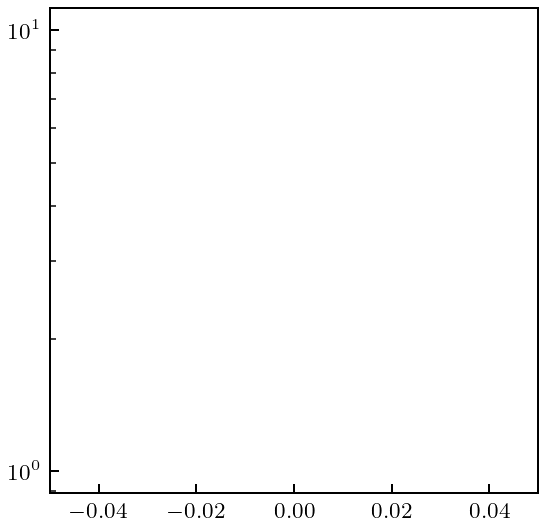

In [20]:
# create figure with n_orders subplots
fig_tlab_var_all_ratio, axs_tlab_var_all_ratio = plt.subplots(1, 1, 
                                                              figsize=(3.5,3.5))
axs_tlab_var_all_ratio.semilogy()

In [21]:
# # sets the potential of interest
# ScaleScheme = RKE500MeV

# # choose energy and angle meshes
# t_lab = ScaleScheme.get_data("t_lab")

# t_lab_input = E_to_p(E_lab = t_lab, interaction = "np")
# # X_train_tlab = E_to_p(E_lab = np.array([5, 21, 48, 85, 133, 192, 261]), 
# #                      interaction = "np")[:, None]
# # X_train_tlab = E_to_p(E_lab = np.array([1, 12, 33, 65, 108, 161, 225, 300]), 
# #                      interaction = "np")[:, None]
# X_train_tlab = E_to_p(E_lab = np.array([1, 5, 12, 21, 33, 48, 65, 85, 108, 133, 161, 192, 225, 261, 300, 341]), 
#                      interaction = "np")[:, None]
# t_lab_label = "Relative momentum (MeV)"
# # t_lab_input = t_lab
# # X_train_tlab = np.array([5, 21, 48, 85, 133, 192, 261])[:, None]
# # t_lab_label = "Lab energy (MeV)"

# X_tlab = t_lab_input[:, None]
# # t_lab_subset = t_lab_input[0::10]
# t_lab_subset = X_train_tlab[:, 0]

# degrees = ScaleScheme.get_data("degrees")

# # degrees_input = degrees
# # X_train_deg = np.array([1, 30, 60, 90, 120, 150, 179])[:, None]
# # degrees_label = "Scattering angle (degrees)"
# degrees_input = -np.cos(np.radians(degrees))
# # X_train_deg = -np.cos(np.radians(np.array([1, 30, 60, 90, 120, 150, 179])))[:, None]
# X_train_deg = -np.cos(np.radians(np.array([41, 60, 76, 90, 104, 120, 139])))[:, None]
# degrees_label = "Negative cosine"

# X_deg = degrees_input[:, None]
# # degrees_subset = degrees_input[0::10]
# degrees_subset = X_train_deg[:, 0]

Lambda_b_vars = Lambda_b_coeffs
mpi_eff_vars = Lambda_b_coeffs
# Lambda_b_vars = 570
# mpi_eff_vars = 138

# calculates ratio
p_type_vars = "pprel"
p_grid_vars = p_approx(p_name = p_type_vars, 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = degrees).T
Q_type_vars = "sum"
ratio_vars = Q_approx(p = p_grid_vars, 
                 Q_parametrization = Q_type_vars, 
                 Lambda_b = Lambda_b_vars, 
                 m_pi = mpi_eff_vars,
                 single_expansion=False)

In [22]:
axs_tlab_var_all_array = np.array([])

# extracts data
obs_data_name_list = ["DSG", "D", "AXX", "AYY", "A", "PB"]
obs_data_label_list = [r"$\frac{d \sigma}{d \Omega}$", 
                       r"$D$", r"$A_{xx}$", r"$A_{yy}$", r"$A$", r"$A_{y}$"]

for idx, obs_data_name_vars in enumerate(obs_data_name_list):
    obs_data_vars = ScaleScheme.get_data(obs_data_name_vars)
    
    # sets reference scale
    if obs_data_name_vars == "DSG":
        yref_vars = obs_data_vars[-1, :, :]
    else:
        yref_vars = np.ones(np.shape(obs_data_vars)[1:])

    # extracts coefficients
    coeffs_flattened_vars = gm.coefficients(
                np.reshape(obs_data_vars, (np.shape(obs_data_vars)[0], np.shape(obs_data_vars)[1] * np.shape(obs_data_vars)[2])).T, 
                ratio=np.reshape(ratio_vars, np.shape(ratio_vars)[0] * np.shape(ratio_vars)[1]),
                ref=np.reshape(yref_vars, np.shape(yref_vars)[0] * np.shape(yref_vars)[1]), 
                orders=ScaleScheme.orders_full)
    coeffs_surfaces_vars = np.reshape(coeffs_flattened_vars.T, np.shape(obs_data_vars))

#     axs_tlab_var_all_array = np.array([])

    # plots at each energy in mesh
    for t in t_lab_subset:
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                          length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                               2 * (np.max(degrees_input) - np.min(degrees_input)))
                   ) + WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_deg, 
               np.reshape(coeffs_surfaces_vars[:, np.isin(t_lab_input, t), :].T, 
                          (len(degrees), 
                           np.shape(coeffs_surfaces_vars)[0]))[np.isin(degrees_input, X_train_deg), :])
        pred, std = gp.predict(X_deg, return_std=True)
        underlying_std = gp.cov_factor_
#         axs_tlab_var_all.scatter(t, 
#                     underlying_std, 
#     #                 c = 'green')
#                     c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        axs_tlab_var_all_array = np.append(axs_tlab_var_all_array, underlying_std)
        
axs_tlab_var_all_array = np.reshape(axs_tlab_var_all_array, 
                                    (len(obs_data_name_list), len(t_lab_subset)))

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.45911316e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 40, 'nit': 6, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.05690851e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 37, 'nit': 4, 'warnflag

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.17835662e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 37, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.30418005e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 35, 'nit': 3, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.1812919e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 37, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b term

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.75602763e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.4586541e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.32160954e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 30, 'nit': 3, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b ter

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.32835446e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 35, 'nit': 2, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00010253]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.20729048e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 37, 'nit': 3, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b termina

In [23]:
axs_tlab_var_all_ratio.scatter(list(range(len(obs_data_name_list))), 
    [np.max(axs_tlab_var_all_array[l, :]) / np.min(axs_tlab_var_all_array[l, :]) for l in range(len(axs_tlab_var_all_array))], 
    marker = 'o', 
    edgecolors = 'green',
    label = r'$Q_{\mathrm{sum}}(p_{\mathrm{rel}} \geq 25\,\mathrm{MeV}, m_{\pi}^{\star}, \Lambda_{b}^{\star})$',
#     edgecolors = 'green', 
#     label = r'2D ALLOBS, all $p_{\mathrm{rel}} > 25\,\mathrm{MeV}$',
    linewidths = 2,
    s = 90, 
    facecolors = 'none')
axs_tlab_var_all_ratio.scatter(list(range(len(obs_data_name_list))), 
    [np.max(axs_tlab_var_all_array[l, 4:]) / np.min(axs_tlab_var_all_array[l, 4:]) for l in range(len(axs_tlab_var_all_array))], 
    marker = 's', 
#     c = 'red', 
#     label = r'OPAAT, $p_{\mathrm{rel}} > 125\,\mathrm{MeV}$', 
    c = 'green', 
    label = r'$Q_{\mathrm{sum}}(p_{\mathrm{rel}} \geq 125\,\mathrm{MeV}, m_{\pi}^{\prime}, \Lambda_{b}^{\prime})$',
    s = 90)
axs_tlab_var_all_ratio.legend(loc = 'upper right', 
                              fontsize = 10,
                              handletextpad=0.02,
                              borderpad=0.2)

axs_tlab_var_all_ratio.set_xticklabels([""] + obs_data_label_list + [""], fontsize = 10)
axs_tlab_var_all_ratio.tick_params(axis = 'y', labelsize = 10)
axs_tlab_var_all_ratio.set_xlim(-1, len(obs_data_name_list))
axs_tlab_var_all_ratio.set_ylim(0.9, 160)

# axs_tlab_var_all.axhspan(0, np.min(axs_tlab_var_all_array[4:-2]), alpha=0.2, color='green')
# axs_tlab_var_all.axhspan(np.max(axs_tlab_var_all_array[4:-2]), 4, alpha=0.2, color='green')

# saves figures
fig_tlab_var_all_ratio.savefig('figures2/' + 'var_ratios' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string)

C:\Users\pjmil\AppData\Local\Temp\ipykernel_14636\146185900.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs_tlab_var_all_ratio.set_xticklabels([""] + obs_data_label_list + [""], fontsize = 10)


#### Plots of scattering-angle length scale and variance by order

C:\Users\pjmil\AppData\Local\Temp\ipykernel_14636\1094911782.py:59: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_tlab_ls.flat)[o].scatter(t,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_14636\1094911782.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_tlab_var.flat)[o].scatter(t,
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated

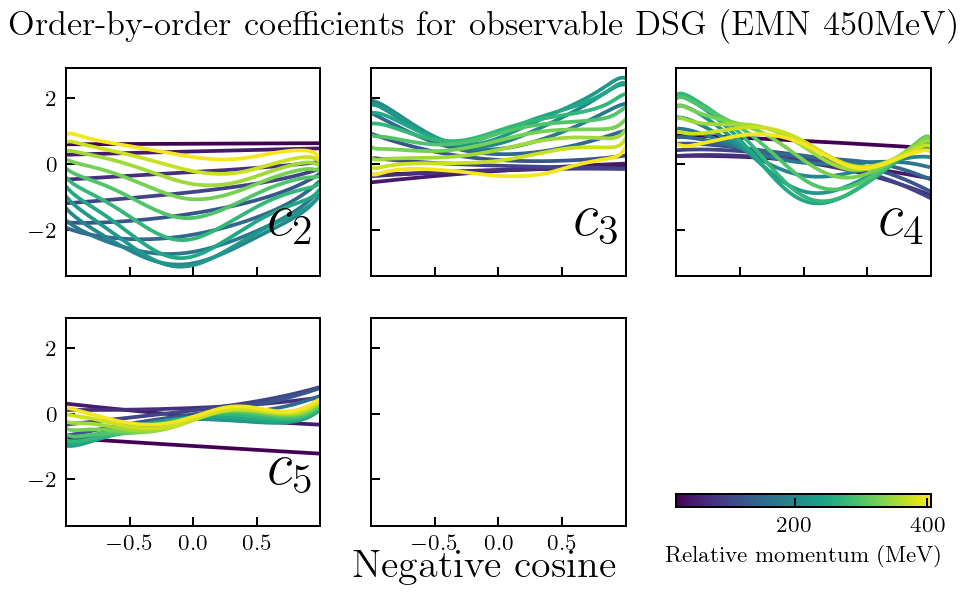

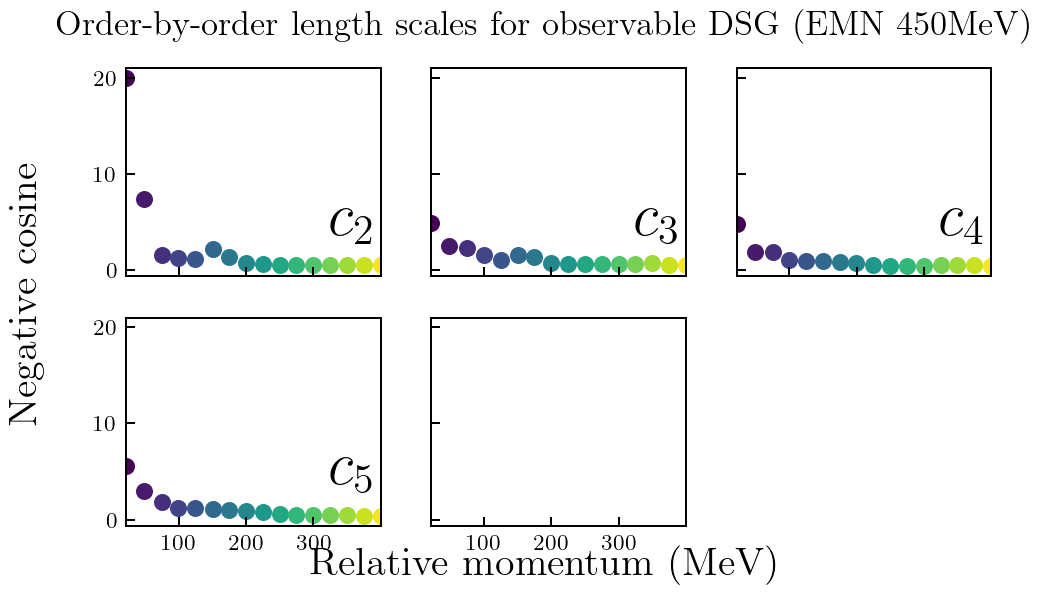

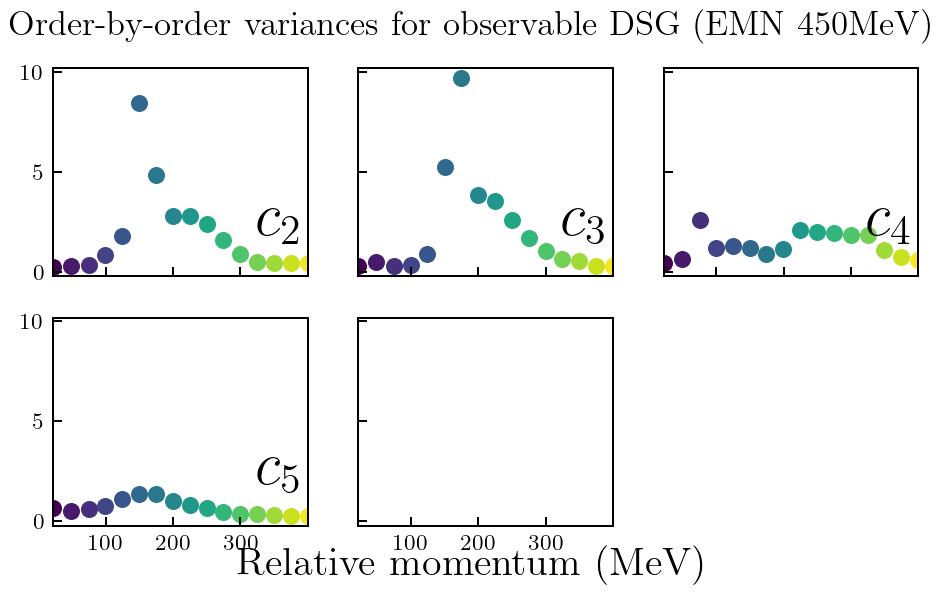

In [24]:
# choose colormap and fix to different energies
cmap_tlab = mpl.cm.viridis
norm_tlab = mpl.colors.Normalize(vmin=np.min(t_lab_input), vmax=np.max(t_lab_input))

# create figure with n_orders subplots
fig_tlab_coeffs, axs_tlab_coeffs = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_tlab_coeffs.supxlabel(degrees_label, size = 16)
fig_tlab_coeffs.suptitle('Order-by-order coefficients for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# create figure with n_orders subplots
fig_tlab_ls, axs_tlab_ls = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_tlab_ls.supxlabel(t_lab_label, size = 16)
fig_tlab_ls.supylabel(degrees_label, size = 16)
fig_tlab_ls.suptitle('Order-by-order length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# create figure with n_orders subplots
fig_tlab_var, axs_tlab_var = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_tlab_var.supxlabel(t_lab_label, size = 16)
fig_tlab_var.suptitle('Order-by-order variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# plot at each energy in mesh
for o in range(np.shape(coeffs_surfaces)[0] - 1):
    (axs_tlab_coeffs.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_coeffs.flat)[o].transAxes, 
                       size = 24)
    (axs_tlab_ls.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_ls.flat)[o].transAxes, 
                       size = 24)
    (axs_tlab_var.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_var.flat)[o].transAxes, 
                       size = 24)
        
    for t in t_lab_subset:
        (axs_tlab_coeffs.flat)[o].plot(degrees_input, 
                    coeffs_surfaces[o + 1, np.isin(t_lab_input, t), :].T, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                      length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                           10 * (np.max(degrees_input) - np.min(degrees_input)))
               ) + WhiteKernel(1e-5, noise_level_bounds='fixed'),
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_deg, 
               (coeffs_surfaces[o + 1, np.isin(t_lab_input, t), :].T)[np.isin(degrees_input, X_train_deg)])
        ls_fit = np.exp(gp.kernel_.theta)
        (axs_tlab_ls.flat)[o].scatter(t, 
                    ls_fit, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        
        pred, std = gp.predict(X_deg, return_std=True)
        underlying_std = gp.cov_factor_
        (axs_tlab_var.flat)[o].scatter(t, 
                    underlying_std, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))

fig_tlab_coeffs.delaxes(axs_tlab_coeffs[-1, -1])        
fig_tlab_coeffs.colorbar(mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab), 
            ax = axs_tlab_coeffs[-1, -1],
             orientation='horizontal', label=t_lab_label)

fig_tlab_ls.delaxes(axs_tlab_ls[-1, -1])
fig_tlab_var.delaxes(axs_tlab_var[-1, -1])

# saves figures
fig_tlab_coeffs.savefig('figures2/' + 'coeffs' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_tlab_ls.savefig('figures2/' + 'ls' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_tlab_var.savefig('figures2/' + 'var' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

#### Plots of scattering-angle length scale and variance over all orders

C:\Users\pjmil\AppData\Local\Temp\ipykernel_14636\1824043933.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs_tlab_ls_all.scatter(t,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_14636\1824043933.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs_tlab_var_all.scatter(t,
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally 

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.78568914e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 38, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "


[82.58030423 -0.89200051]


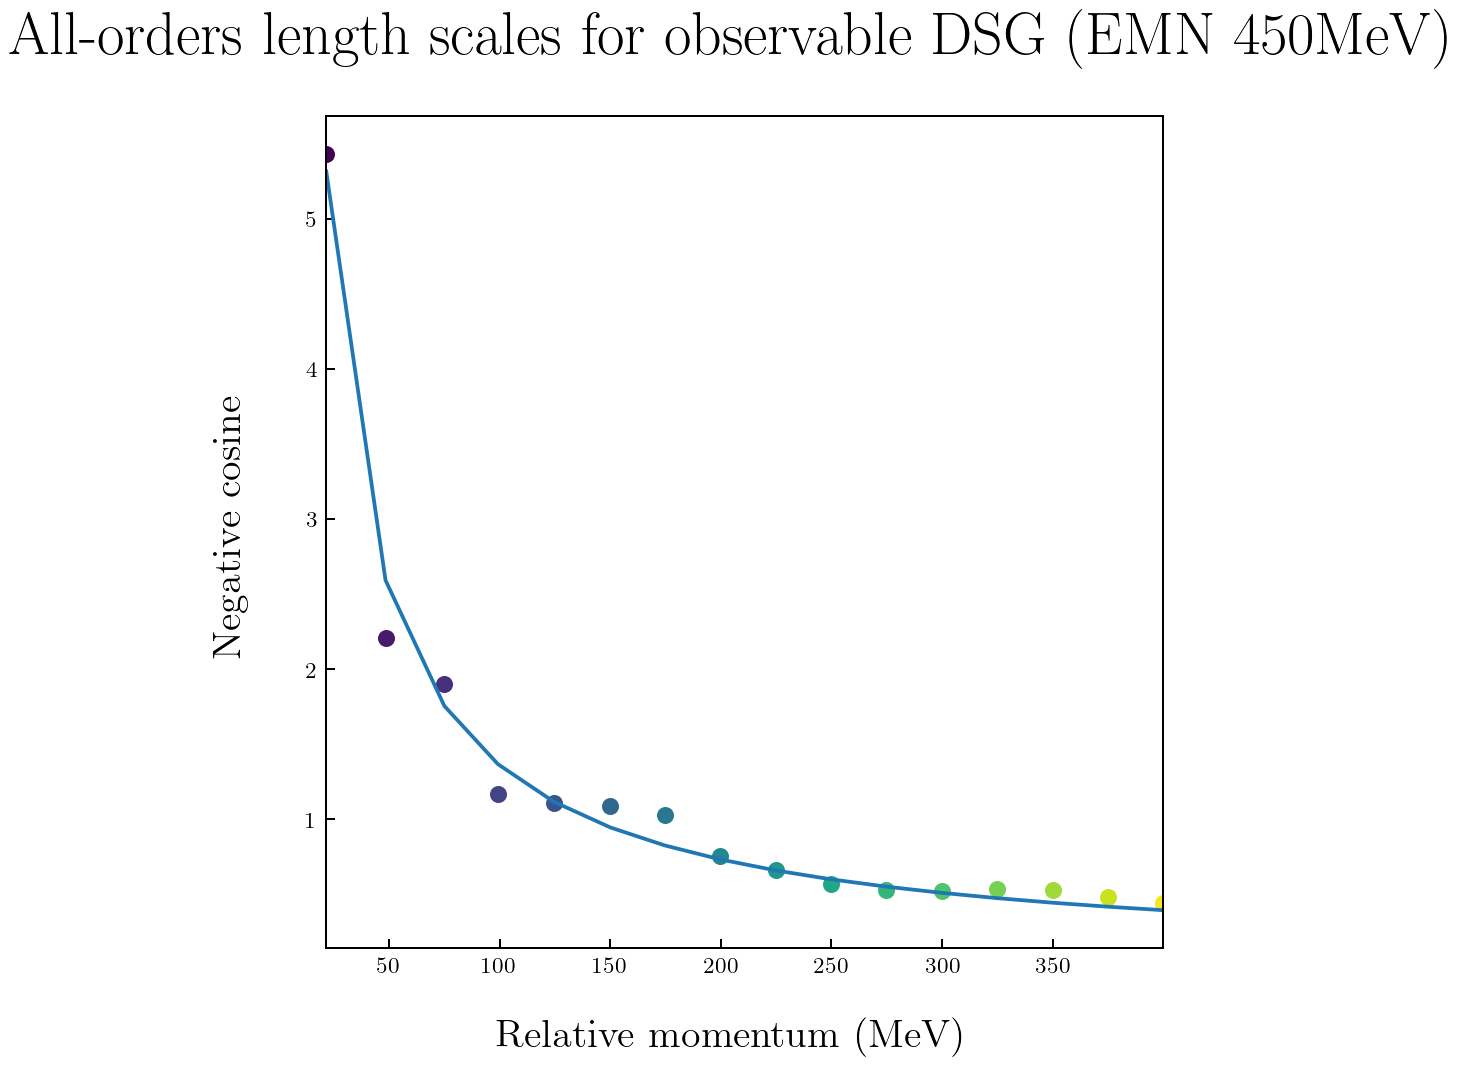

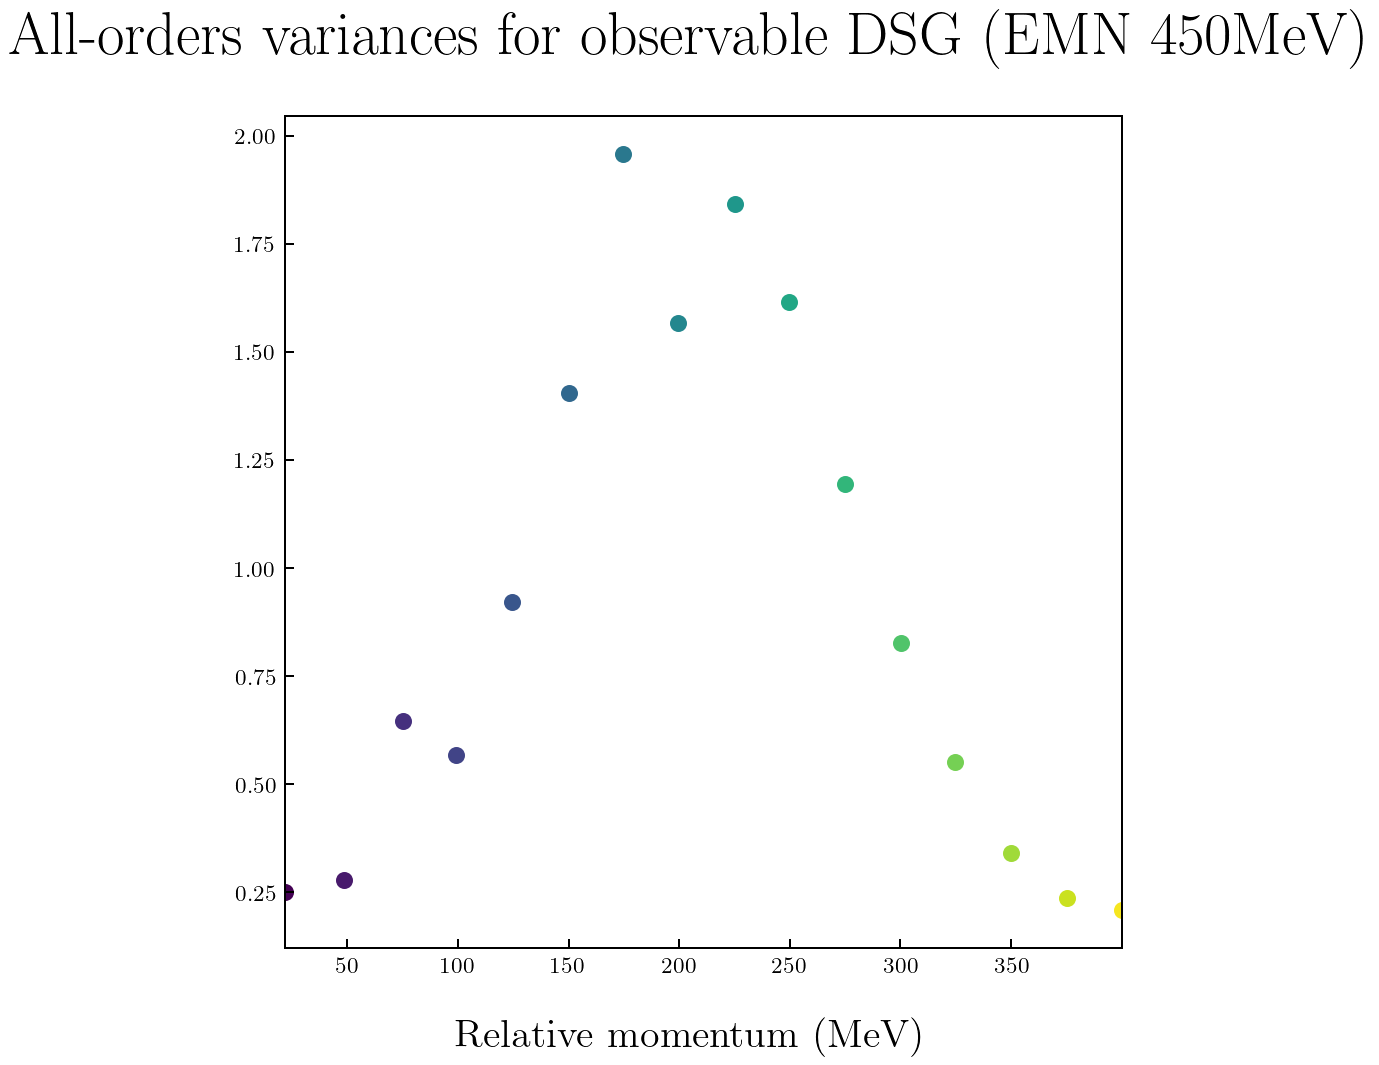

In [25]:
# create figure with n_orders subplots
fig_tlab_ls_all, axs_tlab_ls_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_tlab_ls_all.supxlabel(t_lab_label, size = 16)
fig_tlab_ls_all.supylabel(degrees_label, size = 16)
fig_tlab_ls_all.suptitle('All-orders length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_tlab_ls_all.semilogx()
# axs_tlab_ls_all.semilogy()

axs_tlab_ls_all_array = np.array([])
axs_tlab_var_all_array = np.array([])

# create figure with n_orders subplots
fig_tlab_var_all, axs_tlab_var_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_tlab_var_all.supxlabel(t_lab_label, size = 16)
fig_tlab_var_all.suptitle('All-orders variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_tlab_var_all.semilogx()
# axs_tlab_var_all.semilogy()

# plots at each energy in mesh
for t in t_lab_subset:
    gp = gm.ConjugateGaussianProcess(
        RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                      length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                           10 * (np.max(degrees_input) - np.min(degrees_input)))
               ) + WhiteKernel(1e-5, noise_level_bounds='fixed'), 
        center=0, 
        disp=0, 
        df=1,
        scale=1, 
        n_restarts_optimizer=100, 
        random_state=None,
        sd=None)
    gp.fit(X_train_deg, 
           np.reshape(coeffs_surfaces[:, np.isin(t_lab_input, t), :].T, 
                      (len(degrees), 
                       np.shape(coeffs_surfaces)[0]))[np.isin(degrees_input, X_train_deg), :])
    ls_fit = np.exp(gp.kernel_.theta)
    axs_tlab_ls_all.scatter(t, 
                ls_fit, 
                c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
    axs_tlab_ls_all_array = np.append(axs_tlab_ls_all_array, ls_fit)
    pred, std = gp.predict(X_deg, return_std=True)
    underlying_std = gp.cov_factor_
    axs_tlab_var_all.scatter(t, 
                underlying_std, 
#                 c = 'green')
                c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
    axs_tlab_var_all_array = np.append(axs_tlab_var_all_array, underlying_std)

# sets fitting function and plots the results
def power(x, a, b):
    return a * x**b
def exponent(x, a, b):
    return a * np.exp(b * x)

popt_power, pcov_power = curve_fit(power, t_lab_subset, axs_tlab_ls_all_array)
print(popt_power)
axs_tlab_ls_all.plot(t_lab_subset, power(t_lab_subset, *popt_power))

# popt_exponent, pcov_exponent = curve_fit(exponent, 
#                                          t_lab_subset, 
#                                          axs_tlab_ls_all_array, 
#                                          p0=(241, -0.00846))
# print(popt_exponent)
# axs_tlab_ls_all.plot(t_lab_subset, exponent(t_lab_subset, *popt_exponent))

# axs_tlab_var_all.axhspan(0, np.min(axs_tlab_var_all_array[4:-2]), alpha=0.2, color='green')
# axs_tlab_var_all.axhspan(np.max(axs_tlab_var_all_array[4:-2]), 4, alpha=0.2, color='green')

# saves figures
fig_tlab_ls_all.savefig('figures2/' + 'ls' + '_' + 'tlab_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_tlab_var_all.savefig('figures2/' + 'var' + '_' + 'tlab_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

#### Plots of lab-energy length scale and variance by order

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.26147606e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 38, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\AppData\Local\Temp\ipykernel_14636\14480488.py:58: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_deg_ls.flat)[o - 1].scatter(d,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_14636\14480488.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length 

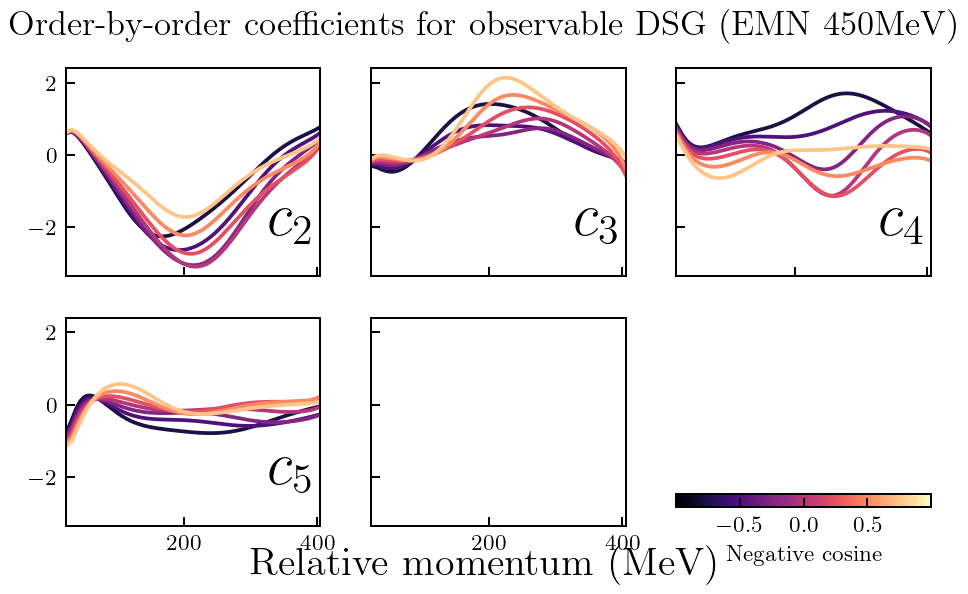

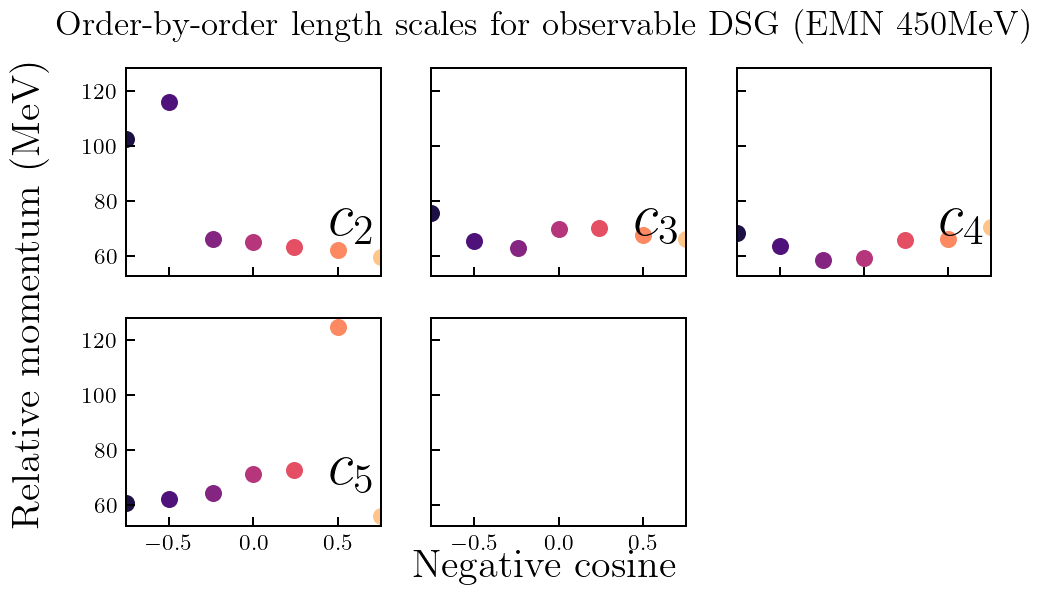

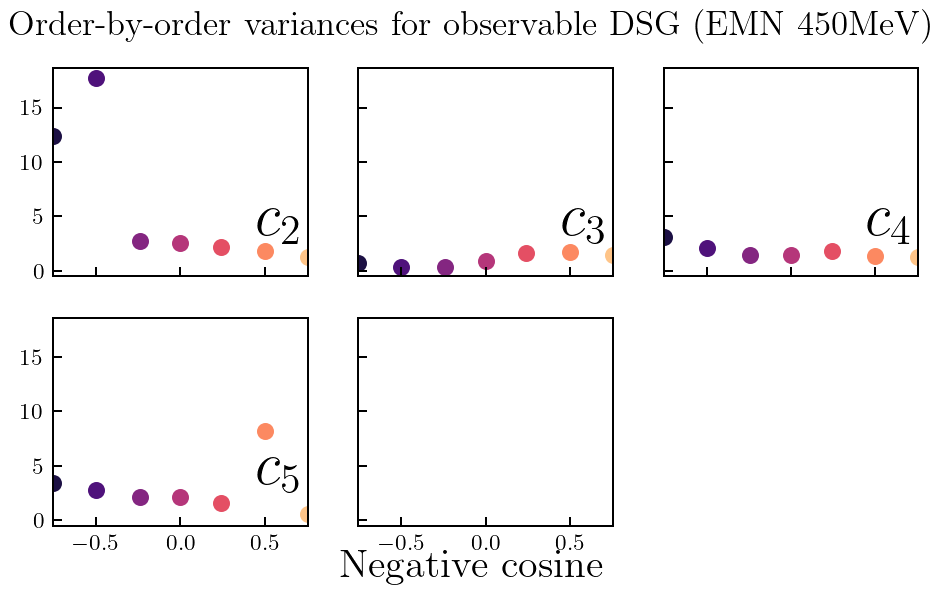

In [26]:
# choose colormap and fix to different energies
cmap_deg = mpl.cm.magma
norm_deg = mpl.colors.Normalize(vmin=np.min(degrees_input), vmax=np.max(degrees_input))

# create figure with n_orders subplots
fig_deg_coeffs, axs_deg_coeffs = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_deg_coeffs.supxlabel(t_lab_label, size = 16)
fig_deg_coeffs.suptitle('Order-by-order coefficients for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# create figure with n_orders subplots
fig_deg_ls, axs_deg_ls = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_deg_ls.supxlabel(degrees_label, size = 16)
fig_deg_ls.supylabel(t_lab_label, size = 16)
fig_deg_ls.suptitle('Order-by-order length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# create figure with n_orders subplots
fig_deg_var, axs_deg_var = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_deg_var.supxlabel(degrees_label, size = 16)
fig_deg_var.suptitle('Order-by-order variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# plots at each angle in mesh
for o in range(1, np.shape(coeffs_surfaces)[0]):
    (axs_deg_coeffs.flat)[o - 1].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o]}}}$', 
                       transform=(axs_deg_coeffs.flat)[o - 1].transAxes, 
                       size = 24)
    (axs_deg_ls.flat)[o - 1].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o]}}}$', 
                       transform=(axs_deg_ls.flat)[o - 1].transAxes, 
                       size = 24)
    (axs_deg_var.flat)[o - 1].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o]}}}$', 
                       transform=(axs_deg_var.flat)[o - 1].transAxes, 
                       size = 24)
        
    for d in degrees_subset:
        (axs_deg_coeffs.flat)[o - 1].plot(t_lab_input, 
                    coeffs_surfaces[o, :, np.isin(degrees_input, d)].T, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))
        
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=60,
                      length_scale_bounds=(12, 300)) + \
                      WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_tlab, 
               (coeffs_surfaces[o, :, np.isin(degrees_input, d)].T)[np.isin(t_lab_input, X_train_tlab)])
        ls_fit = np.exp(gp.kernel_.theta)
        (axs_deg_ls.flat)[o - 1].scatter(d, 
                    ls_fit, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))
        
        pred, std = gp.predict(X_tlab, return_std=True)
        underlying_std = gp.cov_factor_
        (axs_deg_var.flat)[o - 1].scatter(d, 
                    underlying_std, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

fig_deg_coeffs.delaxes(axs_deg_coeffs[-1, -1])        
fig_deg_coeffs.colorbar(mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg), 
            ax = axs_deg_coeffs[-1, -1],
             orientation='horizontal', label=degrees_label)

fig_deg_ls.delaxes(axs_deg_ls[-1, -1])
fig_deg_var.delaxes(axs_deg_var[-1, -1])

# saves figures
fig_deg_coeffs.savefig('figures2/' + 'coeffs' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_deg_ls.savefig('figures2/' + 'ls' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_deg_var.savefig('figures2/' + 'var' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

#### Plots of lab-energy length scale and variance over all orders

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.12314615e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 42, 'nit': 7, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\AppData\Local\Temp\ipykernel_14636\4123097312.py:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs_deg_ls_all.scatter(d,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_14636\4123097312.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matche

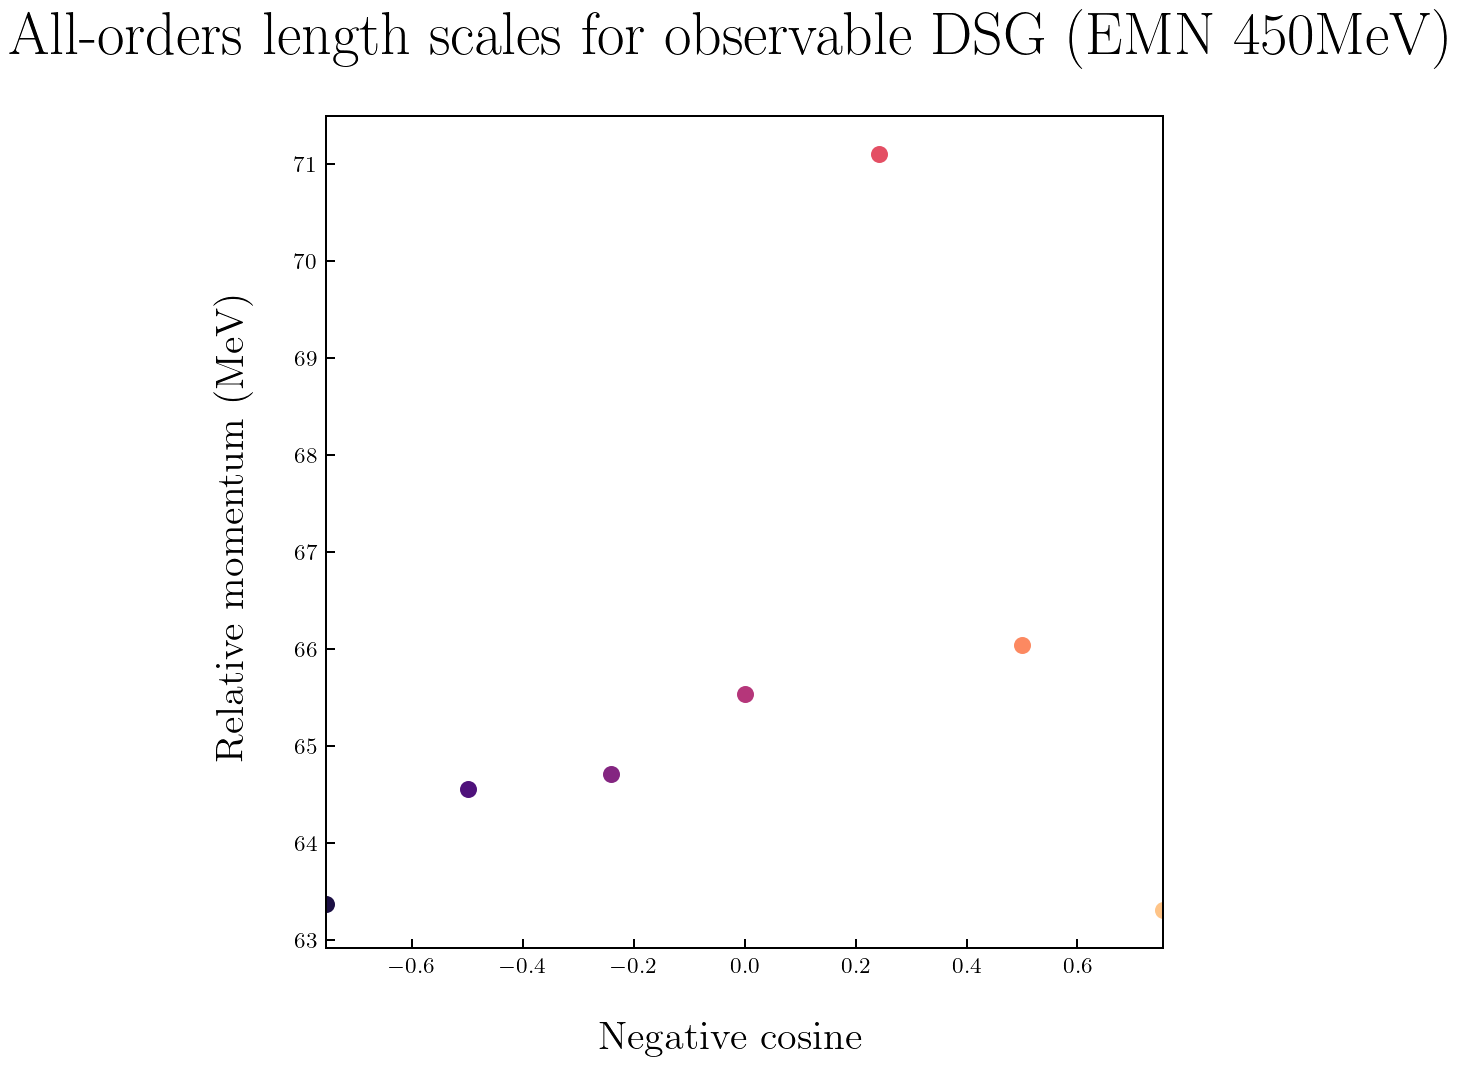

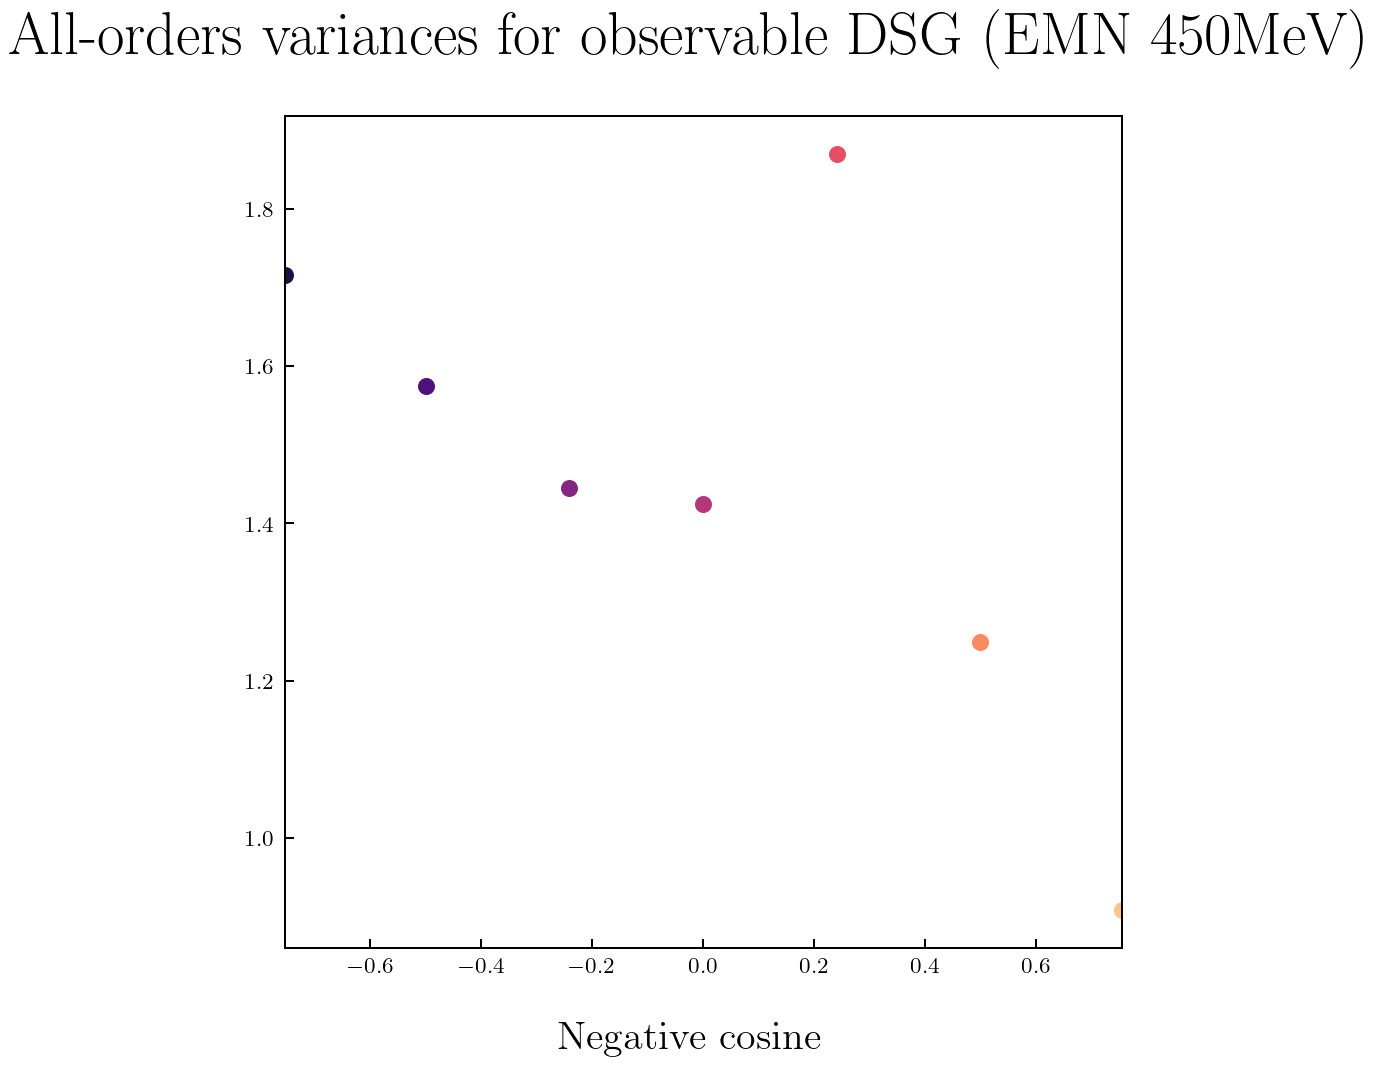

In [27]:
# create figure with n_orders subplots
fig_deg_ls_all, axs_deg_ls_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_deg_ls_all.supxlabel(degrees_label, size = 16)
fig_deg_ls_all.supylabel(t_lab_label, size = 16)
fig_deg_ls_all.suptitle('All-orders length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_deg_ls_all.semilogx()
# axs_deg_ls_all.semilogy()

# create figure with n_orders subplots
fig_deg_var_all, axs_deg_var_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_deg_var_all.supxlabel(degrees_label, size = 16)
fig_deg_var_all.suptitle('All-orders variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_deg_var_all.semilogx()
# axs_deg_var_all.semilogy()

# plots at each angle in mesh
for d in degrees_subset:
    gp = gm.ConjugateGaussianProcess(
        RBF(length_scale=60,
                  length_scale_bounds=(12, 300)) + \
                  WhiteKernel(1e-5, noise_level_bounds='fixed'), 
        center=0, 
        disp=0, 
        df=1,
        scale=1, 
        n_restarts_optimizer=100, 
        random_state=None,
        sd=None)
    gp.fit(X_train_tlab, 
           np.reshape(coeffs_surfaces[:, :, np.isin(degrees_input, d)].T, 
                     (len(t_lab), 
                     np.shape(coeffs_surfaces)[0]))[np.isin(t_lab_input, X_train_tlab), :])
    ls_fit = np.exp(gp.kernel_.theta)
    axs_deg_ls_all.scatter(d, 
                ls_fit, 
                c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

    pred, std = gp.predict(X_tlab, return_std=True)
    underlying_std = gp.cov_factor_
    axs_deg_var_all.scatter(d, 
                underlying_std, 
                c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

# saves figures
fig_deg_ls_all.savefig('figures2/' + 'ls' + '_' + 'deg_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_deg_var_all.savefig('figures2/' + 'var' + '_' + 'deg_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

In [28]:
1/0

ZeroDivisionError: division by zero

## Plots $Q$ as a constant at different slices in momentum and fits to linear curve

In [ ]:
# ScaleSchemeQ_list = [EMN450MeV, EMN500MeV, EMN550MeV]
ScaleSchemeQ_list = [EKM0p8fm, EKM0p9fm, EKM1p0fm, EKM1p1fm, EKM1p2fm]
# ScaleSchemeQ_list = [GT1p2fm, GT1p1fm, GT1p0fm, GT0p9fm]
# ScaleSchemeQ_list = [RKE550MeV, RKE500MeV, RKE450MeV, RKE400MeV]

# fixed values of relative momentum where fitting will take place
Elab_fit_pts = np.array([1, 5, 12, 21, 
                         33, 48, 65, 85, 
                         108, 133, 161, 192, 
                         225, 261, 300, 341])
prel_fit_pts = E_to_p(E_lab = Elab_fit_pts, interaction = "np")

ls_deg_vals = np.linspace(0.01, 4, 100, dtype=np.dtype('f4'))
q_vals = np.linspace(0.01, 1.01, 100, dtype=np.dtype('f4'))

mesh_cart_q = gm.cartesian(q_vals, np.log(ls_deg_vals))

QVariable = RandomVariable(var=q_vals,
                                user_val=0.3,
                                name='Q',
                                label="Q",
                                units="",
                                ticks=[0.2, 0.4, 0.6, 0.8],
                                logprior=np.zeros(len(q_vals)),
                                logprior_name="noprior",
                                marg_bool=True)
LsDegVariable = RandomVariable(var=ls_deg_vals,
                               user_val=None,
                               name='lsdeg',
                               label="\ell_{\Theta}",
                               units="",
                               ticks=[],
                               logprior=np.zeros(len(ls_deg_vals)),
                               logprior_name="noprior",
                               marg_bool=False)
variables_array = np.array([QVariable, LsDegVariable])

# ALLOBS for angle input spaces
plot_obs_list = [["DSG", "D", "AXX", "AYY", "A", "AY"]]
obs_name_grouped_list = ["ALLOBS"]
obs_labels_grouped_list = [r'Obs.']
mesh_cart_grouped_list = [[mesh_cart_q, mesh_cart_q, mesh_cart_q, mesh_cart_q,
                           mesh_cart_q, mesh_cart_q]]

ratio_fn = ratio_fn_posterior_const
ratio_fn_kwargs = {
                  "Q" : 0.3
}
log_likelihood_fn = log_likelihood_const
log_likelihood_fn_kwargs = {}

Q_fit_pts = np.array([])
Q_fit_stddev = np.array([])

orders_q = 3

for elfp in Elab_fit_pts:
    stats_array, _ = generate_posteriors(
        nn_interaction="np",
        scale_scheme_bunch_array=ScaleSchemeQ_list,
        Q_param_method_array=["sum"],
        p_param_method_array=["pprel"],
        input_space_deg=["cos"],
        input_space_tlab=["prel"],
        Elab_slice = elfp,
        t_lab_train_pts=np.array([1, 12, 33, 65, 108, 161, 225, 300]),
        degrees_train_pts=np.array([41, 60, 76, 90, 104, 120, 139]),
        orders_from_ho=orders_q,
        orders_excluded=[],
        orders_names_dict=None,
        orders_labels_dict=None,
        LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
        LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
        m_pi_eff=141,
        Lambdab=480,
        print_all_classes=False,
        savefile_type="png",

        plot_posterior_curvewise_bool=True,
        plot_corner_curvewise_bool=False,
        use_data_curvewise_bool=False,
        save_data_curvewise_bool=False,
        save_posterior_curvewise_bool=False,

        plot_obs_list = plot_obs_list,
        obs_name_grouped_list = obs_name_grouped_list,
        obs_labels_grouped_list = obs_labels_grouped_list,
        mesh_cart_grouped_list = mesh_cart_grouped_list,
        variables_array_curvewise = variables_array,
        
        ratio_fn_posterior = ratio_fn,
        ratio_fn_kwargs_posterior = ratio_fn_kwargs,
        log_likelihood_fn_posterior = log_likelihood_fn,
        log_likelihood_fn_kwargs_posterior = log_likelihood_fn_kwargs,

        plot_posterior_pointwise_bool=False,
        save_posterior_pointwise_bool=False,

        variables_array_pointwise = np.array([0]),

        filename_addendum="",
    )
    print("stats_array = " + str(stats_array))
    Q_fit_pts = np.append(Q_fit_pts, stats_array[[i % 3 == 0 for i in range(np.shape(stats_array)[0])]])
    Q_fit_stddev = np.append(Q_fit_stddev, stats_array[[i % 3 == 2 for i in range(np.shape(stats_array)[0])]])
print(Q_fit_pts)
print(Q_fit_stddev)

In [ ]:
# # # Q MAP values and standard deviations for N4LO+, as read off from program output
# # Q_fit_pts_n4lop = np.array([0.25539218679628944, 0.30739589576038534, 0.33251839648034964, 0.34028703571334384, 
# #                      0.36255619919811605, 0.3933116576700463, 0.40951965293549675, 0.4241664015589035, 
# #                      0.4436712091861928, 0.4616942598203498, 0.4765219942192681, 0.5065393066068069, 
# #                      0.5196787505400745, 0.5264884158162878, 0.5291951325009854, 0.5335299521335803])
# # Q_fit_stddev_n4lop = np.array([0.006587518885345782, 0.009877855309062716, 0.008881269426116611,
# #                               0.010213551910992812, 0.012276369269087583, 0.014528041606449937, 
# #                               0.015862930102590433, 0.015500875012189217, 0.01631681177335528, 
# #                               0.01752575934551553, 0.018445927879855252, 0.01897341936426428, 
# #                               0.01947613196003879, 0.019050463990497514, 0.01959528973531811, 
# #                               0.019411249252802767, ])

# # # Q MAP values and standard deviations for N4LO+, as read off from program output
# # Q_fit_pts_n4lop = np.array([0.2497776782603705, 0.304210429940448, 0.33031968596754935, 0.3392091343595447, 
# #                      0.36501709542352045, 0.396415383602405, 0.41904388404716325, 0.4325567533165633, 
# #                      0.459273841523802, 0.48002571322555854, 0.4875569847913034, 0.5151223433642074, 
# #                      0.541176529068885, 0.5583836821839612, 0.5703943472363621, 0.5823980513789563])
# # Q_fit_stddev_n4lop = np.array([0.006396968227156461, 0.008494445779166944, 0.008998790282543244,
# #                               0.01019895373385017, 0.011099849089075553, 0.013122247410566987, 
# #                               0.01487349498239098, 0.013705205549886506, 0.015130898250506402, 
# #                               0.015632546689561277, 0.014920132142788176, 0.016197619656719255, 
# #                               0.01827450859449251, 0.018929085303850745, 0.019585921717928226, 
# #                               0.01941791347822765, ])

# # Q MAP values and standard deviations for N4LO+, as read off from program output
# Q_fit_pts_n4lop = np.array([0.24232323, 0.2928283, 0.32313132, 0.3332323, 
#                      0.36353534, 0.39383838, 0.41404042, 0.43424243, 
#                      0.46454546, 0.47464648, 0.4948485, 0.5251515, 
#                      0.54535353, 0.5756566, 0.5958586, 0.6160606])
# Q_fit_stddev_n4lop = np.array([0.005977614214516567, 0.009368233860685289,0.009143220593991917,
#                               0.009821763916107703, 0.011492467687130225, 0.012967827860193442, 
#                               0.014140095316316818, 0.014000319833628065, 0.014580509016496192, 
#                               0.016397929193113, 0.01697684404073451, 0.018782915493929284, 
#                               0.02011448604989059, 0.02046004552568438, 0.020696060137969357, 
#                               0.021258922361654015, ])

# # # Q MAP values and standard deviations for N4LO+, as read off from program output
# # Q_fit_pts_n4lop = np.array([0.24719174459078966, 0.2969213086587521, 0.32632769758943236, 0.3370786772184073, 
# #                      0.3593831677896919, 0.3891328270827121, 0.4116968723421862, 0.43461527321925697, 
# #                      0.4556271613764822, 0.47150709128511203, 0.4895364690714762, 0.5254181552315628, 
# #                      0.5539320712120861, 0.5829760607974903, 0.6125750114375481, 0.6402585473235496])
# # Q_fit_stddev_n4lop = np.array([0.0078055084705822494, 0.008790133078322956, 0.009716254018182196,
# #                               0.010604707772095599, 0.012249116360391965, 0.014870398539126485, 
# #                               0.015547232577610844, 0.015442774182576653, 0.01715554502506231, 
# #                               0.019614529832998703, 0.021599910248714802, 0.02252194210859835, 
# #                               0.023417859186012663, 0.024069738489073043, 0.024398492690041327, 
# #                               0.024531611303852972])

In [ ]:
# from sklearn.linear_model import LinearRegression

# fig_fit, ax_fit = plt.subplots(figsize=(3.5,3.5))

# def q_sum(x, lambda_b, m_pi):
#     return (x + m_pi) / (m_pi + lambda_b)

# # ax_fit.errorbar(prel_fit_pts, Q_fit_pts_n3lo, yerr = Q_fit_stddev_n3lo,
# #                 color = 'tab:blue', label = 'N3LO', fmt = 'o')
# # model_n3lo = LinearRegression()
# # model_n3lo.fit(prel_fit_pts.reshape(-1, 1), Q_fit_pts_n3lo, sample_weight=1/Q_fit_stddev_n3lo)
# # ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
# #             model_n3lo.predict(E_to_p(t_lab, interaction = 'np').reshape(-1, 1)), color = 'tab:blue')
# # print("N3LO: slope = " + str(model_n3lo.coef_[0]))
# # print("N3LO: intercept = " + str(model_n3lo.intercept_))
# # print("N3LO: Lambda_b = " + str(1 / model_n3lo.coef_[0]))
# # print("N3LO: m_eff = " + str(model_n3lo.intercept_ / model_n3lo.coef_[0]) + "\n")

# # ax_fit.errorbar(prel_fit_pts, Q_fit_pts_n4lo, yerr = Q_fit_stddev_n4lo,
# #                 color = 'tab:red', label = 'N$^{4}$LO ($Q$ constant, ALLOBS)', fmt = 'o')
# # model_n4lo = LinearRegression()
# # model_n4lo.fit(prel_fit_pts.reshape(-1, 1), Q_fit_pts_n4lo, sample_weight=1/Q_fit_stddev_n4lo)
# # ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
# #             model_n4lo.predict(E_to_p(t_lab, interaction = 'np').reshape(-1, 1)), color = 'tab:red')
# # print("N4LO: slope = " + str(model_n4lo.coef_[0]))
# # print("N4LO: intercept = " + str(model_n4lo.intercept_))
# # print("N4LO: Lambda_b = " + str(1 / model_n4lo.coef_[0]))
# # print("N4LO: m_eff = " + str(model_n4lo.intercept_ / model_n4lo.coef_[0]) + "\n")

# # ax_fit.errorbar(prel_fit_pts, Q_fit_pts_n4lop, yerr = Q_fit_stddev_n4lop,
# #                 color = 'tab:purple', label = r'$Q$ (pointwise)', fmt = 'o')
# # model_n4lop = LinearRegression()
# # model_n4lop.fit(prel_fit_pts.reshape(-1, 1), Q_fit_pts_n4lop, sample_weight=1/Q_fit_stddev_n4lop)
# # ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
# #             model_n4lop.predict(E_to_p(t_lab, interaction = 'np').reshape(-1, 1)), color = 'tab:purple')
# # print("N4LO+: slope = " + str(model_n4lop.coef_[0]))
# # print("N4LO+: intercept = " + str(model_n4lop.intercept_))
# # print("N4LO+: Lambda_b = " + str(1 / model_n4lop.coef_[0]))
# # print("N4LO+: m_eff = " + str(model_n4lop.intercept_ / model_n4lop.coef_[0]) + "\n")

# # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
# ax_fit.errorbar(prel_fit_pts, Q_fit_pts, yerr = 2 * Q_fit_stddev,
#                 color = 'tab:purple', label = r'$Q$ (pointwise)', fmt = 'o', )
# # fits the points to a line
# popt, pcov = scipy.optimize.curve_fit(q_sum, prel_fit_pts, Q_fit_pts, 
#                                      sigma = Q_fit_stddev)
# # plots the line of best fit
# ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
#             q_sum(E_to_p(E_lab = t_lab, interaction = 'np'), 
#                   popt[0], popt[1]), 
#             color = 'tab:purple', 
#            label = rf"$\Lambda_{{b}} = {popt[0]:3.0f}\,\mathrm{{MeV}}, m_{{\mathrm{{eff}}}} = {popt[1]:3.0f}\,\mathrm{{MeV}}$")
# # prints the best fit values
# print("N4LO+: Lambda_b = " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0, 0])) + " MeV")
# print("N4LO+: m_eff = " + str(popt[1]) + " +/- " + str(np.sqrt(pcov[1, 1])) + " MeV\n")

# # plots Qsum(prel) with Lambda_b and m_pi values extracted from the total cross section posterior pdf
# # ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
# #            Q_approx(p = E_to_p(E_lab = t_lab, interaction = 'np'), 
# #                    Q_parametrization = 'sum', 
# #                     Lambda_b = 990, 
# #                     m_pi = 350), 
# #             color = 'orange', label = r'$\sigma_{\mathrm{tot}}$')
# # # plots Qsum(prel) with Lambda_b and m_pi values extracted from all the 2D observables' posterior pdf
# # ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
# #            Q_approx(p = E_to_p(E_lab = t_lab, interaction = 'np'), 
# #                    Q_parametrization = 'sum', 
# #                     Lambda_b = 570, 
# #                     m_pi = 138), 
# #             color = 'green', label = r'All 2D observables')
# # ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
# #            Q_approx(p = E_to_p(E_lab = t_lab, interaction = 'np'), 
# #                    Q_parametrization = 'max', 
# #                     Lambda_b = 600, 
# #                     m_pi = 200), 
# #             color = 'black', label = r'$Q_{\mathrm{max}}\,(m_{\mathrm{eff}} = 200\,\mathrm{MeV})$')

# # fig_fit.suptitle("MAP $Q$ values and lines of fit", fontsize = 20)
# ax_fit.set_xlabel("$p_{\mathrm{rel}}$ [MeV]", fontsize = 13)
# ax_fit.set_ylabel(r"$Q_{\mathrm{sum}}$", fontsize = 13)
# ax_fit.legend(fontsize = 10, loc = 'upper left')
# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)
# fig_fit.tight_layout()

# # fig_fit.savefig('figures2/' + 'qvsp_linear_' + ScaleSchemeQ.potential_string + ScaleSchemeQ.cutoff_string)

In [ ]:
from sklearn.linear_model import LinearRegression

orders_labels_dict = {6: r'N$^{4}$LO+', 5: r'N$^{4}$LO',
                    4: r'N$^{3}$LO', 3: r'N$^{2}$LO', 2: r'NLO'}
orders_names_dict = {6: r'N4LO+', 5: r'N4LO', 4: r'N3LO', 3: r'N2LO', 2: r'NLO'}

def q_sum(x, lambda_b, m_pi):
        return (x + m_pi) / (m_pi + lambda_b)

# upper = len(ScaleSchemeQ_list) * orders_q

for ss_idx in range(len(ScaleSchemeQ_list)):
    fig_fit, ax_fit = plt.subplots(figsize=(3.5,3.5))
    
    for o_idx in range(orders_q):
        idx_mask = [i % (orders_q * len(ScaleSchemeQ_list)) == 
                 (o_idx + ss_idx * orders_q) for i in range(len(Q_fit_pts))]

        # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
        ax_fit.errorbar(prel_fit_pts, 
                        Q_fit_pts[idx_mask], 
                        yerr = 2 * Q_fit_stddev[idx_mask],
                        color = ScaleSchemeQ_list[ss_idx].cmaps[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx - 1](0.55), 
#                         label = r'$Q$', 
                        fmt = 'o', 
                       zorder = o_idx)
        # fits the points to a line
        popt, pcov = scipy.optimize.curve_fit(q_sum, prel_fit_pts, 
                                            Q_fit_pts[idx_mask], 
                                            sigma = Q_fit_stddev[idx_mask])
        # plots the line of best fit
        ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
                    q_sum(E_to_p(E_lab = t_lab, interaction = 'np'), 
                          popt[0], popt[1]), 
                    color = ScaleSchemeQ_list[ss_idx].cmaps[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx - 1](0.55), 
                   label = orders_labels_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx + 1] + 
                    rf": $\Lambda_{{b}} = {popt[0]:3.0f}\,\mathrm{{MeV}}, m_{{\mathrm{{eff}}}} = {popt[1]:3.0f}\,\mathrm{{MeV}}$", 
                   zorder = o_idx)
        # prints the best fit values
        print(orders_names_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx + 1] + ": Lambda_b = " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0, 0])) + " MeV")
        print(orders_names_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx + 1] + ": m_eff = " + str(popt[1]) + " +/- " + str(np.sqrt(pcov[1, 1])) + " MeV\n")

    # fig_fit.suptitle("MAP $Q$ values and lines of fit", fontsize = 20)
    ax_fit.set_xlabel("$p_{\mathrm{rel}}$ [MeV]", fontsize = 13)
    ax_fit.set_ylabel(r"$Q_{\mathrm{sum}}$", fontsize = 13)
    ax_fit.legend(fontsize = 8, loc = 'upper left')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    fig_fit.tight_layout()

    fig_fit.savefig('figures2/' + 'qvsp_linear_' + 
        ScaleSchemeQ_list[ss_idx].potential_string + 
        ScaleSchemeQ_list[ss_idx].cutoff_string)